# **Time Series Forecasting Tutorial**
## **Model Building: Single Step Ahead**

![Image](https://www.ufv.ca/media/2015/headers/programs/arts/Economics-Banner-Image.jpg)

[Image Credit](https://www.ufv.ca/media/2015/headers/programs/arts/Economics-Banner-Image.jpg)<br>

This tutorial mainly focuses on the methods widely used to fit models on time series data and provide forecasts for future. <br>

This notebook performs the model building step for the three preselected time series. This involves developing different models for forecasting one stpe ahead of the time series. These methods are as follows:

[Importing Datasets](#c1) <br>
[Defining Some Functions](#c2) <br>
[1. Benchmark Models](#c3) <br>
[2. Linear Regression Method](#c4) <br>
[3. Hybrid Forecasting with Residuals](#c5) <br>
[4. ARIMAX Method](#c6) <br>
[5. Recurrent Neural Networks (RNN)](#c7) <br>
[6. Long Short-Term Memory (LSTM) Networks](#c8) <br>
[----- 6.1. Vanilla LSTM](#c81) <br>
[----- 6.2. Stacked LSTM](#c82) <br>
[----- 6.3. Bidirectional LSTM](#c83) <br>
[7. Gated Recurrent Unit (GRU)](#c9)<br>


**Note: None of the models developed in this notebook have their optimal performance since hyperparameter tuning was not implemented for them. So, comparing the forecasts of these models is not fair and this notebook has been prepared only to show how to develop different models.**

Main References: <br>
[1] https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/  <br>
[2] https://www.kaggle.com/code/ryanholbrook/forecasting-with-machine-learning <br>
[3] https://towardsdatascience.com/facebooks-prophet-deep-learning-neuralprophet-76796aed1d86 <br>
[4] https://otexts.com/fpp3/prediction-intervals.html <br>
[5] https://github.com/zgana/fpp3-python-readalong/blob/master/05-The-forecasters-toolbox.ipynb



In [3]:
# importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # setting seaborn default for plots. matplotlib.pyplot plots are given a theme.
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from scipy import stats
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
import warnings
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import IPython
import IPython.display
from fbprophet import Prophet

%matplotlib inline

Importing plotly failed. Interactive plots will not work.


<a id='c1'></a> 
#### **Importing Datasets:** 
We first import the data that was prepared in `data_analysis.ipynb`.

In [4]:
# importing the datasets with determined frequency
train1 = pd.read_csv('train1.csv', index_col='date', parse_dates=True)
train2 = pd.read_csv('train2.csv', index_col='date', parse_dates=True)
train3 = pd.read_csv('train3.csv', index_col='date', parse_dates=True)
test1 = pd.read_csv('test1.csv', index_col='date', parse_dates=True)
test2 = pd.read_csv('test2.csv', index_col='date', parse_dates=True)
test3 = pd.read_csv('test3.csv', index_col='date', parse_dates=True)

# set frequency
train1 = train1.asfreq('MS') # monthly
train2 = train2.asfreq('D') # daily
train3 = train3.asfreq('D') # daily
test1 = test1.asfreq('MS') # monthly
test2 = test2.asfreq('D') # daily
test3 = test3.asfreq('D') # daily

<a id="c2"></a>
#### **Defining Some Functions:** 
First, lets define a function for plotting the actual and predicted values for the time series.

In [5]:
# define a function to plot the time series for actual train, predicted train, actual test and predicted test
def plot_ts(train, test, train_pred, test_pred):
    plt.figure(figsize=(14, 3))
    plt.plot(train.index, train.ts, color='k', label='train')
    plt.plot(test.index, test.ts, color='k', alpha=.3, label='test')
    plt.plot(train.index, train_pred, color='C0', label='train_pred')
    plt.plot(test.index, test_pred, color='red', label='test_pred')
    plt.legend(loc='best')
    plt.show()

We also define a function to calculate RMSE of the predictions as follows:

In [6]:
# define a function to calculate the root mean squared error considering the actual and predicted values
def rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

<a id="c3"></a> 
## **1. Benchmark Models:**
#### **1.1 Model Building:**

We consider four benchmark models as follows [[ref]](https://otexts.com/fpp3/simple-methods.html):<br>
**1. Mean method:** The forecasts of all future values are equal to the average (or “mean”) of the historical data.<br>
**2. Naïve method:** The forecasts of all future values are equal to the last observation.<br>
**3. Seasonal naïve method:** For highly seasonal data, the forecasts are equal to the last observed value from the same season (e.g., the same month of the previous year)<br>
**4. Drift method:** A variation on the naïve method is to allow the forecasts to increase or decrease over time, where the amount of change over time (called the drift) is set to be the average change seen in the historical data.

Let's start by applying the four aforementioned methods to the three time series. The functions defined for each method are adopted from [here](https://github.com/zgana/fpp3-python-readalong/blob/master/05-The-forecasters-toolbox.ipynb).

In [6]:
# functions for each benchmark model
class SimpleTSModel:
    """Simple TS model base class."""
    def __init__(self, y):
        """Determine y data and sampling frequency."""
        if not hasattr(y, 'index'):
            y = pd.Series(y)
        if hasattr(y.index, 'inferred_freq'):
            self.y = y.asfreq(y.index.inferred_freq)
            self.freq = self.y.index.freq
        else:
            self.y = y.copy()
            self.freq = None
        
    def fit(self):
        """Nothing to do here, but in other libraries this is a method that does things."""
        return self

    def forecast(self, dt=None, end=None, periods=None):
        """Make a forward-looking prediction."""
        assert sum([dt is None, end is None, periods is None]) == 2
        tmax = self.y.index.max()
        if dt is not None:
            end = tmax + (pd.to_timedelta(dt) if self.freq else dt)
        elif end is not None:
            end = pd.to_datetime(end) if self.freq else end
        elif periods is not None:
            end = tmax + periods * (self.freq or 1)
        return self.predict(tmax + 1 * (self.freq or 1), end)

    def _normalize_times(self, start, end):
        """Do some tedious datetime manipulation."""
        Y = self.y
        t0 = Y.index.min()
        if start is None:
            start = t0
        if end is None:
            end = Y.index.max()
        if self.freq is not None:
            start = pd.to_datetime(start)
            end = pd.to_datetime(end)
        if self.freq:
            index = pd.date_range(t0, end, freq=self.freq)
        else:
            index = np.arange(t0, end+1)
        return start, end, index

class TSMean(SimpleTSModel):
    """The future will look like the average of the past."""
    def predict(self, start=None, end=None):
        # value is always the mean
        Y = self.y
        start, end, index = self._normalize_times(start, end)
        m = Y.mean()
        out = pd.Series(m, index=index)
        out = out.loc[start:].copy()
        return out

class TSNaive(SimpleTSModel):
    """Tomorrow will look like today."""
    def predict(self, start=None, end=None):
        # tomorrow probably same as today
        Y = self.y
        start, end, index = self._normalize_times(start, end)
        out = pd.Series(np.nan, index=index)
        out.loc[:Y.index.max()] = Y
        out = out.shift(1)
        out.loc[Y.index.max():] = Y.iloc[-1]
        out = out.loc[start:].copy()
        return out.copy()

class TSNaiveSeasonal(SimpleTSModel):
    """Next year will fluctuate the same way as this year."""
    def __init__(self, y, lag):
        super(TSNaiveSeasonal, self).__init__(y)
        self.lag = lag
        assert self.y.index.min() + lag * (self.freq or 1) < self.y.index.max(), \
            'lag must be less than input timeseries'
    
    def predict(self, start=None, end=None):
        # tomorrow probably same as this time last year/month/whatever
        Y, lag = self.y, self.lag
        start, end, index = self._normalize_times(start, end)
        out = pd.Series(np.nan, index=index)
        out.loc[:Y.index.max()] = Y
        out = out.shift(lag)
        i = 0
        while np.isnan(out.iloc[-1]):
            mask = out.isna()
            out[mask] = out.shift(lag)[mask]
            i += 1
        out = out.loc[start:].copy()
        return out.copy()

class TSDrift(SimpleTSModel):
    """Draw a line from t=0 thru today, and extrapolate to tomorrow."""
    def predict(self, start=None, end=None):
        # value extrapolated based on slope wrt first observation
        # TODO: might be slightly wrong
        # doesn't *quite* agree with R's RW(Y~drift()) ?
        Y = self.y
        Y0 = Y.values[0]
        YT = Y.shift(-1)
        start, end, index = self._normalize_times(start, end)
        YT = pd.Series(np.nan, index=index)
        YT.loc[Y.index.min():Y.index.max()] = Y
        YT = YT.shift(1)
        YT.iloc[0] = Y.iloc[0]
        h = pd.Series(1, index=index)
        extrap_mask = YT.isna()
        h.loc[YT.isna()] = np.arange(1, extrap_mask.sum()+1)
        YT.loc[extrap_mask] = Y.iloc[-1]
        x = np.maximum(1, np.arange(len(YT)) - 1)
        out = YT + h * ((YT - Y0) / x)
        out.iloc[0] = np.nan
        out = out.loc[start:].copy()
        return out.copy()

**For `train1`:**

In [7]:
# create the benchmark models
m = TSMean(train1.ts)
n = TSNaive(train1.ts).fit()
s = TSNaiveSeasonal(train1.ts, 12) # 12 months seasonality
dr = TSDrift(train1.ts)

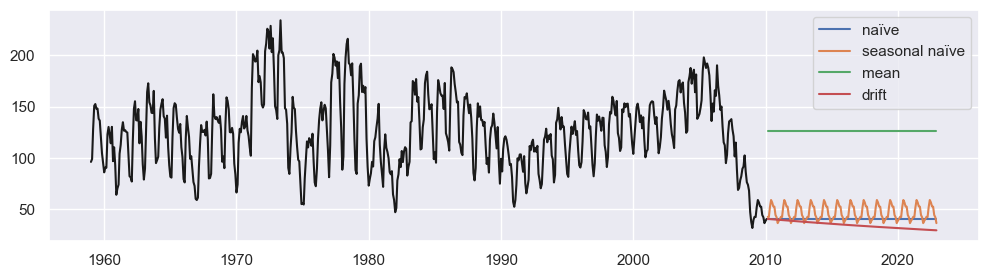

In [8]:
# plot the results
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(train1.ts, color='k')
ax.plot(n.forecast(end=test1.index[-1]), color='C0', label='naïve')
ax.plot(s.forecast(end=test1.index[-1]), color='C1', label='seasonal naïve')
ax.plot(m.forecast(end=test1.index[-1]), color='C2', label='mean')
ax.plot(dr.forecast(end=test1.index[-1]), color='C3', label='drift')
ax.legend()

In [9]:
# RMSE of the benchmark models
print('RMSE of naïve: {:.2f}'.format(rmse(test1.ts, n.forecast(end=test1.index[-1]))))
print('RMSE of seasonal naïve: {:.2f}'.format(rmse(test1.ts, s.forecast(end=test1.index[-1]))))
print('RMSE of mean: {:.2f}'.format(rmse(test1.ts, m.forecast(end=test1.index[-1]))))
print('RMSE of drift: {:.2f}'.format(rmse(test1.ts, dr.forecast(end=test1.index[-1]))))

RMSE of naïve: 59.78
RMSE of seasonal naïve: 53.92
RMSE of mean: 43.04
RMSE of drift: 66.39


**For `train2`:**

In [10]:
# create the benchmark models
m = TSMean(train2.ts)
n = TSNaive(train2.ts).fit()
s = TSNaiveSeasonal(train2.ts, 7) # weekly seasonality
dr = TSDrift(train2.ts)

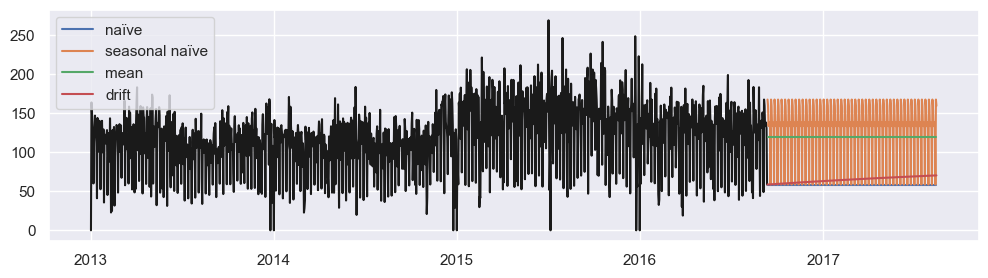

In [11]:
# plot the results
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(train2.ts, color='k')
ax.plot(n.forecast(end=test2.index[-1]), color='C0', label='naïve')
ax.plot(s.forecast(end=test2.index[-1]), color='C1', label='seasonal naïve')
ax.plot(m.forecast(end=test2.index[-1]), color='C2', label='mean')
ax.plot(dr.forecast(end=test2.index[-1]), color='C3', label='drift')
ax.legend()

In [12]:
# RMSE of the benchmark models
print('RMSE of naïve: {:.2f}'.format(rmse(test2.ts, n.forecast(end=test2.index[-1]))))
print('RMSE of seasonal naïve: {:.2f}'.format(rmse(test2.ts, s.forecast(end=test2.index[-1]))))
print('RMSE of mean: {:.2f}'.format(rmse(test2.ts, m.forecast(end=test2.index[-1]))))
print('RMSE of drift: {:.2f}'.format(rmse(test2.ts, dr.forecast(end=test2.index[-1]))))

RMSE of naïve: 85.06
RMSE of seasonal naïve: 35.30
RMSE of mean: 44.16
RMSE of drift: 79.70


**For `train3`:**

In [13]:
# create the benchmark models
m = TSMean(train3.ts)
n = TSNaive(train3.ts).fit()
s = TSNaiveSeasonal(train3.ts, 1)
dr = TSDrift(train3.ts)

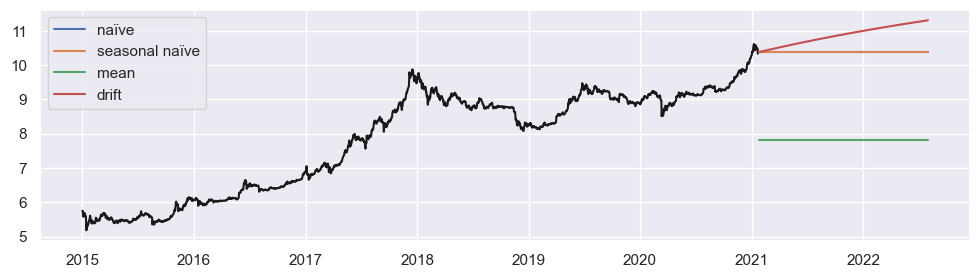

In [14]:
# plot the results
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(train3.ts, color='k')
ax.plot(n.forecast(end=test3.index[-1]), color='C0', label='naïve')
ax.plot(s.forecast(end=test3.index[-1]), color='C1', label='seasonal naïve')
ax.plot(m.forecast(end=test3.index[-1]), color='C2', label='mean')
ax.plot(dr.forecast(end=test3.index[-1]), color='C3', label='drift')
ax.legend()

In [15]:
# RMSE of the benchmark models
print('RMSE of naïve: {:.2f}'.format(rmse(test3.ts, n.forecast(end=test3.index[-1]))))
print('RMSE of seasonal naïve: {:.2f}'.format(rmse(test3.ts, s.forecast(end=test3.index[-1]))))
print('RMSE of mean: {:.2f}'.format(rmse(test3.ts, m.forecast(end=test3.index[-1]))))
print('RMSE of drift: {:.2f}'.format(rmse(test3.ts, dr.forecast(end=test3.index[-1]))))

RMSE of naïve: 0.38
RMSE of seasonal naïve: 0.38
RMSE of mean: 2.82
RMSE of drift: 0.55


#### **1.2 Residuals (errors) Analysis:**
Residuals are useful in checking whether a model has adequately captured the information in the data. A good forecasting method will yield residuals with the following properties [[ref]](https://otexts.com/fpp3/diagnostics.html):

**1) The residuals are uncorrelated.** If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts. <br>
**2) The residuals have zero mean.** If they have a mean other than zero, then the forecasts are biased. <br>

Any forecasting method that does not satisfy these properties can be improved. However, that does not mean that forecasting methods that satisfy these properties cannot be improved.

In addition to these essential properties, it is useful (but not necessary) for the residuals to also have the following two properties.

**3) The residuals have constant variance.** This is known as “homoscedasticity”. <br>
**4) The residuals are normally distributed.** <br>

If either of these properties is not satisfied, then the forecasting method can be modified to give better forecasts. Adjusting for bias is easy: if the residuals have mean m, then simply subtract m from all forecasts and the bias problem is solved. Fixing the correlation problem is harder.

Let's conduct the residual analysis for some of the benchmark models over the second time series as an example. The plotting functions are adopted from [here](https://github.com/zgana/fpp3-python-readalong/blob/master/05-The-forecasters-toolbox.ipynb).

In [16]:
# defining functions for plotting the characteristics of the residuals
def plot_tsresiduals(Y, y, acf_lags=np.r_[1:26]):
    """Plot timeseries residuals for ground truth Y and estimate y."""
    fig = plt.figure(figsize = (12, 5))
    gs = plt.GridSpec(2, 2, figure=fig)
    axs = np.array([fig.add_subplot(gs[i,j]) for j in (0,1) for i in (0,1)])
    rax, hax, acfax, pacfax = axs
    mask = ~(np.isnan(Y) | np.isnan(y))
    Y, y = Y[mask], y[mask]
    dy = Y - y
    lim = 1.1 * max(-dy.min(), dy.max())
    lim = -lim, lim
    rax.plot(dy)
    rax.set(ylim=lim, title='Residuals')
    sns.distplot(dy, bins=np.linspace(lim[0], lim[1], 22),
                 hist=True, kde=True, rug=True, ax=hax)
    hax.set(title='Residual Distribution')
    sm.graphics.tsa.plot_acf(dy, lags=acf_lags, ax=acfax)
    sm.graphics.tsa.plot_pacf(dy, lags=acf_lags, ax=pacfax)
    for a in axs.ravel():
        a.grid()
    plt.tight_layout()
    return fig, axs


def suptitle(fig, text=None, **kw):
    """Add a nice left-aligned suptitle."""
    if text is None:
        fig, text = plt.gcf(), fig
    fig = fig.figure or fig
    fig.text(fig.subplotpars.left, .99, text, ha='left', va='top', size='large', **kw)

In [17]:
# to ignore warnings resulted from the use of 'sns.distplot'
import warnings
warnings.filterwarnings('ignore')

**For `train2`:** <br>
We choose dataset 2 just as an example. The plots can be produced for other methods, too.

In [18]:
# create the benchmark models
m = TSMean(train2.ts)
n = TSNaive(train2.ts).fit()
s = TSNaiveSeasonal(train2.ts, 7) # weekly seasonality
dr = TSDrift(train2.ts)

# create a dataframe to store the results
results = train2.assign(
    mean=m.predict(),
    naive=n.predict(),
    naive_seasonal=s.predict(),
    drift=dr.predict(),
    resid_mean=m.predict() - train2.ts,
    resid_naive=n.predict() - train2.ts,
    resid_naive_seasonal=s.predict() - train2.ts,
    resid_drift=dr.predict() - train2.ts,
)
results.head(10)

,ts,mean,naive,naive_seasonal,drift,resid_mean,resid_naive,resid_naive_seasonal,resid_drift
date,,,,,,,,,
2013-01-01,0.000,120.201756,NaN,NaN,NaN,120.201756,NaN,NaN,NaN
2013-01-02,164.069,120.201756,0.000,NaN,0.000000,-43.867244,-164.069,NaN,-164.069000
2013-01-03,151.582,120.201756,164.069,NaN,328.138000,-31.380244,12.487,NaN,176.556000
2013-01-04,131.411,120.201756,151.582,NaN,227.373000,-11.209244,20.171,NaN,95.962000
2013-01-05,118.613,120.201756,131.411,NaN,175.214667,1.588756,12.798,NaN,56.601667
2013-01-06,60.135,120.201756,118.613,NaN,148.266250,60.066756,58.478,NaN,88.131250
2013-01-07,113.235,120.201756,60.135,NaN,72.162000,6.966756,-53.100,NaN,-41.073000
2013-01-08,130.085,120.201756,113.235,0.000,132.107500,-9.883244,-16.850,-130.085,2.022500
2013-01-09,147.149,120.201756,130.085,164.069,148.668571,-26.947244,-17.064,16.920,1.519571


Here, we only compare the residuals of the predictions obtained by the naive method (poor forecasts) and seasonal naive method (better forecasts).

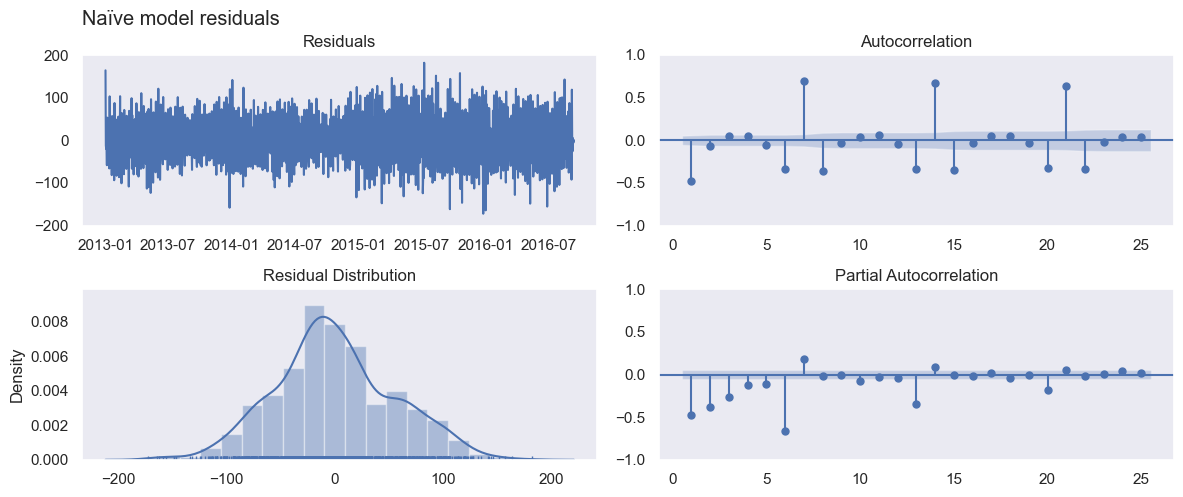

In [19]:
# plot the results for the naive method
plot_tsresiduals(train2.ts, results.naive)
suptitle('Naïve model residuals')
plt.subplots_adjust(top=.9)

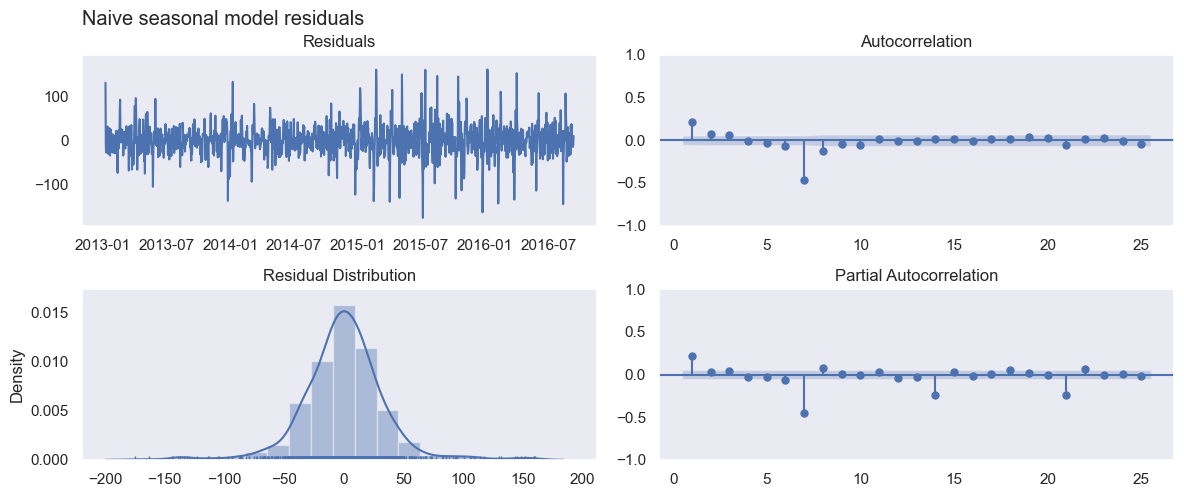

In [20]:
# plot the results for the naive seasonal method
plot_tsresiduals(train2.ts, results.naive_seasonal)
suptitle('Naive seasonal model residuals')
plt.subplots_adjust(top=.9)

By comparing the two above figures, we can clearly see that the seasonal naive method has resulted in better forecasts compared to the naive method. 
- Higher magnitude of the residuals resulted by the naive method (200) compared to the seasonal naive method (100).
- Normal distribution of the residuals resulted by the seasonal naive method.
- Strong autocorrelation and partial autocorrelation values for the residuals resulted by the naive method compared to the seasonal naive method.


**Note:** Also read about **Portmanteau tests for autocorrelation** [here](https://otexts.com/fpp3/diagnostics.html) that can be implemented using `sm.stats.acorr_ljungbox`.

<a id="c4"></a> 

## **2. Linear Regression Method:**


**We can create features as follows:**
> Using `DeterministicProcess` as follows:<br>
> `DeterministicProcess(index, constant, order, drop, seasonal, additional_terms)`
> * `index`: index of the training data <br>
> * `constant`: If `True`, include a constantfor the bias (y_intercept) (if `True`, then the model should not include a constant itself). <br>
> * `order`: order of trend, 1 for linear, 2 for quadratic, 3 for cubic, and so on. <br>
> * `drop`: If `True`, drop terms if necessary to avoid collinearity. <br>
> * `seasonal`: If `True`, use seasonality indicators. It automatically detects the seasonality and creates the one-hot encoded features. <br>
> * `additional_terms`: like [CalendarFourier(freq="A", order=1)], for seasonality by fourier features.<br>

> Seasonality by fourier features using `CalendarFourier(freq, order)`: <br>
> * `freq`:"A"nnual, "Q"uarterly, "M"onthly, "W"eekly, "D"aily, "H"ourly, "T" minutely, "S"econdly. <br>
> * `order`: the order of the fourier features (1 for sine and cosine, 2 for sine, cosine, sine^2, and cosine^2, and so on).

In [21]:
# make a function to return the lag values of a time series
def make_lags(ts, lags):
    return pd.concat({f'y_lag_{i}': ts.shift(i) for i in range(1, lags + 1)}, axis=1)

In [42]:
# make a function for the linear model
def linear_model(train, test, order, lags, seasonal=True, constant=True):
    y = train['ts'] # target variable
    dp = DeterministicProcess(index=train.index,
                              constant=constant, 
                              order=order, 
                              drop=True, 
                              seasonal=seasonal, 
                              )
    # use 'in_sample' to create features for the dates given in the 'index' argument
    X = dp.in_sample()
    if lags > 0:
        # use 'make_lags' to create lags of the target variable
        X = pd.concat([X, make_lags(train['ts'], lags=lags)], axis=1)
        X = X.fillna(0.0)

    # fit the model
    model = LinearRegression(fit_intercept=False)
    model.fit(X,y)
    # make predictions on training data
    train_pred = model.predict(X)
    # make predictions on the test data
    X_test = dp.out_of_sample(steps=len(test))
    if lags > 0:
        X_test = pd.concat([X_test, make_lags(test['ts'], lags=lags)], axis=1)
        # fill the missing values with the last value of the training data
        X_test = X_test.fillna(X.iloc[-1])
        
    test_pred = model.predict(X_test)
    return X, X_test, train_pred, test_pred

**For `train1`:** Monthly temporal resolution
- Trend: Linear >>> using order 1
- Seasonality: Yearly (12) >>> using seasonal indicators (binary features)

**IMPORTANT:** From the data analysis, we have some knowledge of the components of the time series. However, we can try different values for `order`, `lags`, and `seasonal` step-by-step, plot the predictions, and evaluate the residuals and then, modify the above values.

**Note:** The Fourier features are better suited for long seasons over many observations where indicators would be impractical. Fourier features are pairs of sine and cosine curves, one pair for each potential frequency in the season starting with the longest. Fourier pairs modeling annual seasonality would have frequencies: once per year, twice per year, three times per year, and so on. [[ref]](https://www.kaggle.com/code/ryanholbrook/seasonality)

**Note:** Seasonal indicators are what you get if you treat a seasonal period as a categorical feature and apply one-hot encoding.

Input Features:
            const  trend  s(2,12)  s(3,12)  s(4,12)  s(5,12)  s(6,12)  \
date                                                                    
1959-01-01    1.0    1.0      0.0      0.0      0.0      0.0      0.0   
1959-02-01    1.0    2.0      1.0      0.0      0.0      0.0      0.0   
1959-03-01    1.0    3.0      0.0      1.0      0.0      0.0      0.0   

            s(7,12)  s(8,12)  s(9,12)  s(10,12)  s(11,12)  s(12,12)  y_lag_1  \
date                                                                           
1959-01-01      0.0      0.0      0.0       0.0       0.0       0.0      0.0   
1959-02-01      0.0      0.0      0.0       0.0       0.0       0.0     96.2   
1959-03-01      0.0      0.0      0.0       0.0       0.0       0.0     99.0   

            y_lag_2  
date                 
1959-01-01      0.0  
1959-02-01      0.0  
1959-03-01     96.2  


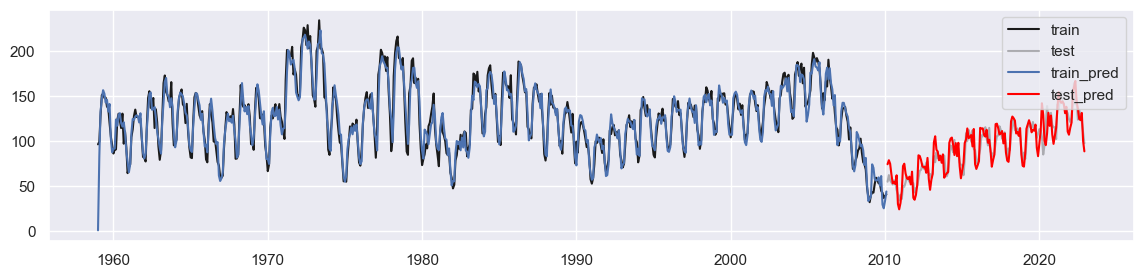

"fig, ax = plt.subplots(figsize=(14, 3))\nax.plot(train1.ts, color='k')\nax.plot(train1.pred_linear, color='C0', label='linear prediction')\nax.plot(test1.ts, color='k', alpha=.3, label='test data')\nax.plot(test1.pred_linear, color='red', label='1-step forecast')\nax.legend()\nplt.show()"

In [23]:
# train the model and make predictions
X, X_test, train_pred, test_pred = linear_model(train1, test1, order=1, lags=2, seasonal=True)
train1['pred_linear'] = train_pred
test1['pred_linear'] = test_pred

print('Input Features:')
print(X.head(3))

# plot the predictions and the actual values on the training data and the test data in one plot
plot_ts(train1, test1, train_pred, test_pred)

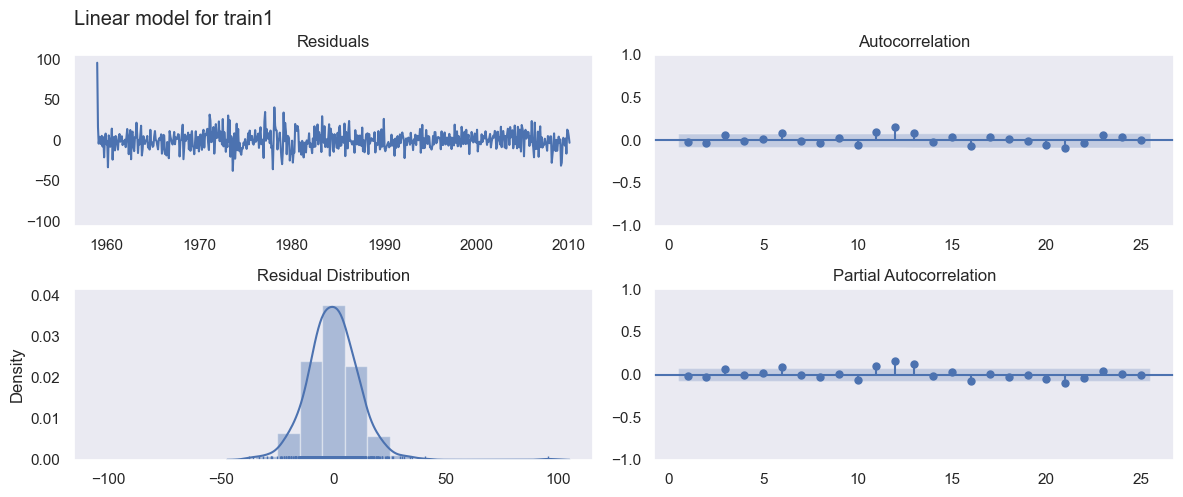

In [24]:
# plot the results for the linear model
plot_tsresiduals(train1.ts, train1['pred_linear'])
suptitle('Linear model for train1')
plt.subplots_adjust(top=.9)

In [25]:
# print rmse on the train and test data
print('RMSE of linear model on train data: {:.2f}'.format(rmse(train1.ts, train1['pred_linear'])))
print('RMSE of linear model on test data: {:.2f}'.format(rmse(test1.ts, test1['pred_linear'])))

RMSE of linear model on train data: 11.51
RMSE of linear model on test data: 12.44


**For `train2`:** daily temporal resolution
- Trend: Linear >>> using order 1
- Seasonality: Weekly (7) >>> using seasonal indicators (binary features)

Input Features:
            const  trend  s(2,7)  s(3,7)  s(4,7)  s(5,7)  s(6,7)  s(7,7)  \
date                                                                       
2013-01-01    1.0    1.0     0.0     0.0     0.0     0.0     0.0     0.0   
2013-01-02    1.0    2.0     1.0     0.0     0.0     0.0     0.0     0.0   
2013-01-03    1.0    3.0     0.0     1.0     0.0     0.0     0.0     0.0   

            y_lag_1  y_lag_2  y_lag_3  y_lag_4  y_lag_5  y_lag_6  y_lag_7  
date                                                                       
2013-01-01    0.000      0.0      0.0      0.0      0.0      0.0      0.0  
2013-01-02    0.000      0.0      0.0      0.0      0.0      0.0      0.0  
2013-01-03  164.069      0.0      0.0      0.0      0.0      0.0      0.0  


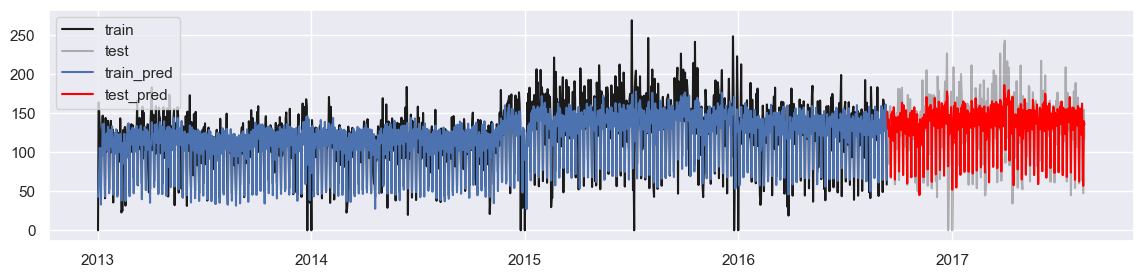

In [26]:
# train the model and make predictions
X, X_test, train_pred, test_pred = linear_model(train2, test2, order=1, lags=7, seasonal=True)
train2['pred_linear'] = train_pred
test2['pred_linear'] = test_pred

print('Input Features:')
print(X.head(3))

# plot the predictions and the actual values on the training data and the test data in one plot
plot_ts(train2, test2, train_pred, test_pred)

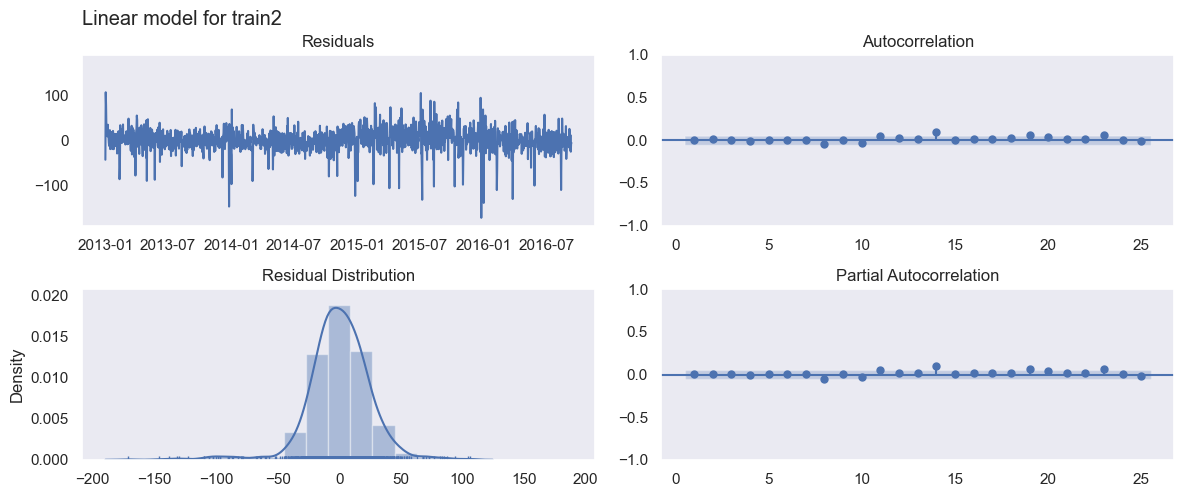

In [27]:
# plot the results for the linear model
plot_tsresiduals(train2.ts, train2['pred_linear'])
suptitle('Linear model for train2')
plt.subplots_adjust(top=.9)

In [28]:
# print rmse on the train and test data
print('RMSE of linear model on train data: {:.2f}'.format(rmse(train2.ts, train2['pred_linear'])))
print('RMSE of linear model on test data: {:.2f}'.format(rmse(test2.ts, test2['pred_linear'])))

RMSE of linear model on train data: 25.97
RMSE of linear model on test data: 29.77


**For `train3`:** daily temporal resolution
- Trend: Linear >>> using order 1
- Seasonality: no seasonality

Input Features:
            const  trend   y_lag_1
date                              
2015-01-01    1.0    1.0  0.000000
2015-01-02    1.0    2.0  5.750186
2015-01-03    1.0    3.0  5.752674


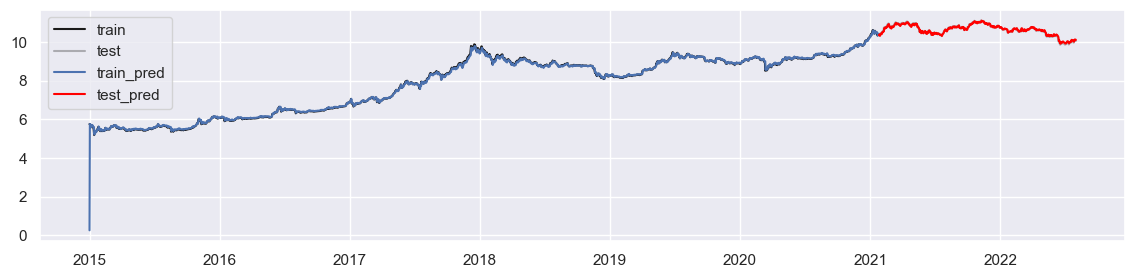

In [29]:
# train the model and make predictions
X, X_test, train_pred, test_pred = linear_model(train3, test3, order=1, lags=1, seasonal=False)
train3['pred_linear'] = train_pred
test3['pred_linear'] = test_pred

print('Input Features:')
print(X.head(3))

# plot the predictions and the actual values on the training data and the test data in one plot
plot_ts(train3, test3, train_pred, test_pred)

In [30]:
# modify the first prediction
train3['pred_linear'][0] = train3['ts'][0]

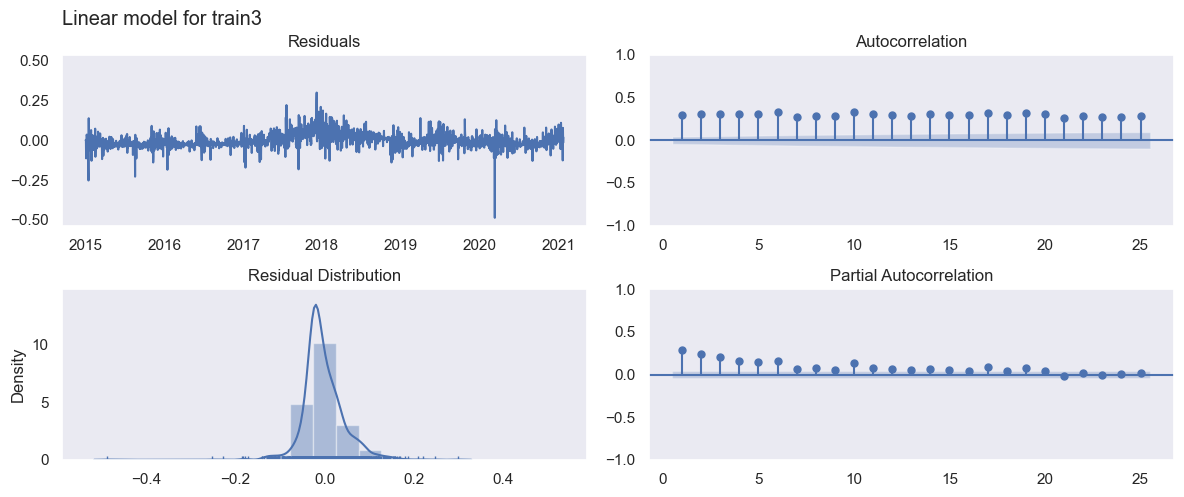

In [31]:
# plot the results for the linear model
plot_tsresiduals(train3.ts, train3['pred_linear'])
suptitle('Linear model for train3')
plt.subplots_adjust(top=.9)

In [32]:
# print rmse on the train and test data
print('RMSE of linear model on train data: {:.2f}'.format(rmse(train3.ts, train3['pred_linear'])))
print('RMSE of linear model on test data: {:.2f}'.format(rmse(test3.ts, test3['pred_linear'])))

RMSE of linear model on train data: 0.05
RMSE of linear model on test data: 0.05


In [206]:
# saving train and test data
train1.to_csv('train1_pred.csv')
test1.to_csv('test1_pred.csv')
train2.to_csv('train2_pred.csv')
test2.to_csv('test2_pred.csv')
train3.to_csv('train3_pred.csv')
test3.to_csv('test3_pred.csv')

<a id='c5'></a>
## **3. Hybrid Forecasting with Residuals:**
it's also possible to use one algorithm for some of the components and another algorithm for the rest. While it's possible to use more than two models, in practice it doesn't seem to be especially helpful. In fact, the most common strategy for constructing hybrids is a simple (usually linear) learning algorithm followed by a complex, non-linear learner like GBDTs or a deep neural net, the simple model typically designed as a "helper" for the powerful algorithm that follows. [[ref]](https://www.kaggle.com/code/ryanholbrook/hybrid-models)

There are generally two ways a regression algorithm can make predictions: either by transforming the features or by transforming the target. `Feature-transforming algorithms` learn some mathematical function that takes features as an input and then combines and transforms them to produce an output that matches the target values in the training set. Linear regression and neural nets are of this kind. 
`Target-transforming algorithms` use the features to group the target values in the training set and make predictions by averaging values in a group; a set of feature just indicates which group to average. Decision trees and nearest neighbors are of this kind.
The important thing is this: feature transformers generally can extrapolate target values beyond the training set given appropriate features as inputs, but the predictions of target transformers will always be bound within the range of the training set. If the time dummy continues counting time steps, linear regression continues drawing the trend line. Given the same time dummy, a decision tree will predict the trend indicated by the last step of the training data into the future forever. Decision trees cannot extrapolate trends. Random forests and gradient boosted decision trees (like XGBoost) are ensembles of decision trees, so they also cannot extrapolate trends. [[ref]](https://www.kaggle.com/code/ryanholbrook/hybrid-models)

This difference is what motivates the hybrid design: use linear regression to extrapolate the trend, transform the target to remove the trend, and apply XGBoost to the detrended residuals. To hybridize a neural net (a feature transformer), you could instead include the predictions of another model as a feature, which the neural net would then include as part of its own predictions. The method of fitting to residuals is actually the same method the gradient boosting algorithm uses, so we will call these `boosted hybrids`; the method of using predictions as features is known as stacking, so we will call these `stacked hybrids`. [[ref]](https://www.kaggle.com/code/ryanholbrook/hybrid-models)

We can implement many different boosted and stacked hybrid models. Here, we only invetigate a simple example. <br>

In the following, we use the linear models already developed, obtain the predictions, calculate the residuals, and fit gradient boosting trees over the residuals. Hence, this approach is in the category of **boosted hybrids**. Here, we do not apply hyperparameters tuning to keep the example simple. So, the performance of the models can be further improver by choosing the optimal hyperparameters.

**For `train1`:**

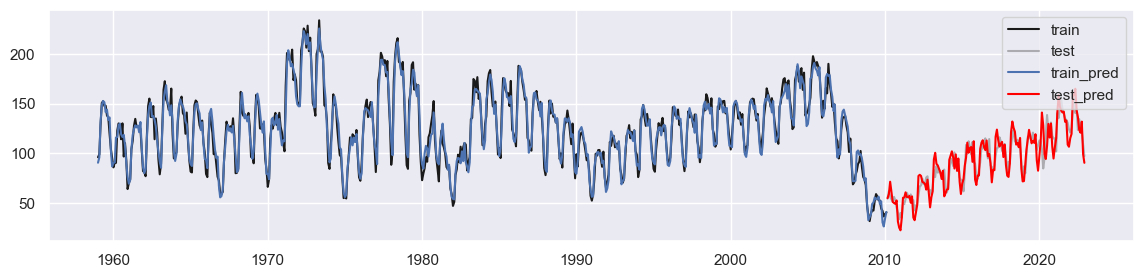

In [90]:
# train the linear model and make predictions
X, X_test, train_pred_lr, test_pred_lr = linear_model(train1, test1, order=1, lags=2, seasonal=True, constant=True)

# calculate the residuals
y_resid_train = train1['ts'] - train_pred_lr
y_resid_test = test1['ts'] - test_pred_lr

# drop the constant and trend columns
'''We can use a different feature set for modeling the residuals using ML models. So, there are many options here.'''
X.drop(['const','trend'], axis=1, inplace=True)
# fit gradient boosting model on the residuals
'''We can use any other ML model here. So, there are many options here.'''
model = GradientBoostingRegressor(n_estimators=50, max_depth=4, random_state=0)
model.fit(X, y_resid_train)

# make predictions on the training data
train_pred_gbt = model.predict(X)
# make predictions on the test data
X_test.drop(['const','trend'], axis=1, inplace=True)
test_pred_gbt = model.predict(X_test)

# add the predictions of the gradient boosting model to the predictions of the linear model
train1['pred_lr_gbt'] = train_pred_lr + train_pred_gbt
test1['pred_lr_gbt'] = test_pred_lr + test_pred_gbt

# plot the predictions and the actual values on the training data and the test data in one plot
plot_ts(train1, test1, train1['pred_lr_gbt'], test1['pred_lr_gbt'])

In [91]:
# print rmse on the train and test data
print('RMSE of hybrid model on train data: {:.2f}'.format(rmse(train1.ts, train1['pred_lr_gbt'])))
print('RMSE of hybrid model on test data: {:.2f}'.format(rmse(test1.ts, test1['pred_lr_gbt'])))

RMSE of hybrid model on train data: 8.63
RMSE of hybrid model on test data: 11.61


**For `train2`:**

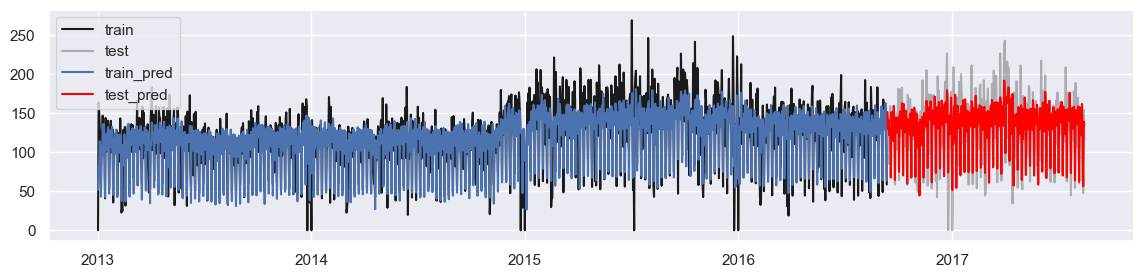

In [100]:
# train the linear model and make predictions
X, X_test, train_pred_lr, test_pred_lr = linear_model(train2, test2, order=1, lags=7, seasonal=True, constant=True)

# calculate the residuals
y_resid_train = train2['ts'] - train_pred_lr
y_resid_test = test2['ts'] - test_pred_lr

# drop the constant and trend columns
'''We can use a different feature set for modeling the residuals using ML models. So, there are many options here.'''
X.drop(['const','trend'], axis=1, inplace=True)
# fit gradient boosting model on the residuals
'''We can use any other ML model here. So, there are many options here.'''
model = GradientBoostingRegressor(n_estimators=10, max_depth=3, random_state=0)
model.fit(X, y_resid_train)

# make predictions on the training data
train_pred_gbt = model.predict(X)
# make predictions on the test data
X_test.drop(['const','trend'], axis=1, inplace=True)
test_pred_gbt = model.predict(X_test)

# add the predictions of the gradient boosting model to the predictions of the linear model
train2['pred_lr_gbt'] = train_pred_lr + train_pred_gbt
test2['pred_lr_gbt'] = test_pred_lr + test_pred_gbt

# plot the predictions and the actual values on the training data and the test data in one plot
plot_ts(train2, test2, train2['pred_lr_gbt'], test2['pred_lr_gbt'])

In [101]:
# print rmse on the train and test data
print('RMSE of hybrid model on train data: {:.2f}'.format(rmse(train2.ts, train2['pred_lr_gbt'])))
print('RMSE of hybrid model on test data: {:.2f}'.format(rmse(test2.ts, test2['pred_lr_gbt'])))

RMSE of hybrid model on train data: 24.75
RMSE of hybrid model on test data: 29.91


**For `train3`:**

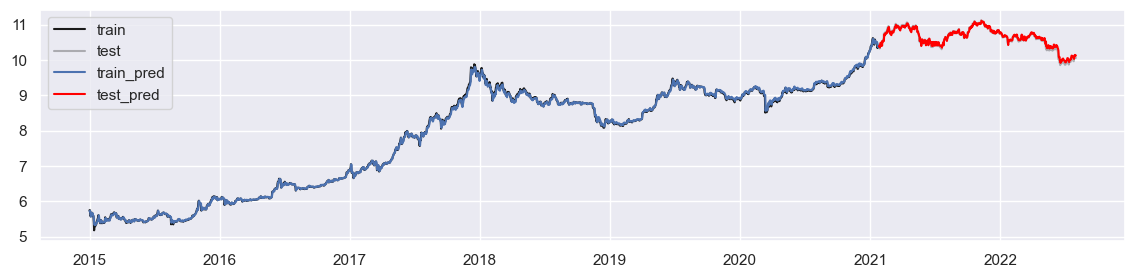

In [108]:
# train the linear model and make predictions
X, X_test, train_pred_lr, test_pred_lr = linear_model(train3, test3, order=1, lags=1, seasonal=False, constant=True)

# calculate the residuals
y_resid_train = train3['ts'] - train_pred_lr
y_resid_test = test3['ts'] - test_pred_lr

# drop the constant and trend columns
'''We can use a different feature set for modeling the residuals using ML models. So, there are many options here.'''
X.drop(['const','trend'], axis=1, inplace=True)
# fit gradient boosting model on the residuals
'''We can use any other ML model here. So, there are many options here.'''
model = GradientBoostingRegressor(n_estimators=50, max_depth=5, random_state=0)
model.fit(X, y_resid_train)

# make predictions on the training data
train_pred_gbt = model.predict(X)
# make predictions on the test data
X_test.drop(['const','trend'], axis=1, inplace=True)
test_pred_gbt = model.predict(X_test)

# add the predictions of the gradient boosting model to the predictions of the linear model
train3['pred_lr_gbt'] = train_pred_lr + train_pred_gbt
test3['pred_lr_gbt'] = test_pred_lr + test_pred_gbt

# plot the predictions and the actual values on the training data and the test data in one plot
plot_ts(train3, test3, train3['pred_lr_gbt'], test3['pred_lr_gbt'])

In [109]:
# print rmse on the train and test data
print('RMSE of hybrid model on train data: {:.2f}'.format(rmse(train3.ts, train3['pred_lr_gbt'])))
print('RMSE of hybrid model on test data: {:.2f}'.format(rmse(test3.ts, test3['pred_lr_gbt'])))

RMSE of hybrid model on train data: 0.04
RMSE of hybrid model on test data: 0.05


In [110]:
# saving train and test data
train1.to_csv('train1_pred.csv')
test1.to_csv('test1_pred.csv')
train2.to_csv('train2_pred.csv')
test2.to_csv('test2_pred.csv')
train3.to_csv('train3_pred.csv')
test3.to_csv('test3_pred.csv')

<a id='c6'></a>
## **4. ARIMAX Method:** 
An ARIMA is a linear regression model developed by the integraion of 3 models including [[ref]](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/):

* AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
* I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
* MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

In an ARIMA(p,d,q):

* p: The number of lag observations included in the model, also called the lag order.
* d: The number of times that the raw observations are differenced, also called the degree of differencing.
* q: The size of the moving average window, also called the order of moving average.

The most general form of the model is `SARIMAX(p, d, q)x(P, D, Q, s)`. It also allows all specialized cases, including

* autoregressive models: AR(p)
* moving average models: MA(q)
* mixed autoregressive moving average models: ARMA(p, q)
* integration models: ARIMA(p, d, q)
* seasonal models: SARIMA(P, D, Q, s)
* regression with errors that follow one of the above ARIMA-type models

This model incorporates both exogenous regressors and trend components through “regression with ARIMA errors”.

A P=1 would make use of the first seasonally offset observation in the model, e.g. t-(s*1). A P=2, would use the last two seasonally offset observations t-(s * 1), t-(s * 2). Similarly, a D of 1 would calculate a first order seasonal difference and a Q=1 would use a first order errors in the model (e.g. moving average). [[ref]](https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/#:~:text=A%20seasonal%20ARIMA%20model%20uses,average%20terms%20at%20lag%20s.)

**NOTE:** One of the main challenges of developing ARIMA models is choosing the right orders of the model. By detrending and deseasonalizing a time series, and then ploting ACF and PACF, we can guess suitable parameters of the model. However, it is still a challenging work. One solution is to define a validation set and a search space for the parameters and implement a grid search or any other optimization approaches to find the best parameters based on the performance of the model on the validation set. It, however, may take a long time if the search space is big.  (For more information about this, look at [HW6_arima_with_statsmodels_1](https://github.com/Behzad-h/HW6_arima_with_statsmodels_1/blob/master/arima_with_statsmodels_1.ipynb))



In [188]:
# define a function for data splitting and model fitting
def arima_model(train, test, orders=(0, 0, 0), seasonal=(0, 0, 0, 0), rolling=False):
    p,d,q = orders
    P,D,Q,S = seasonal
    history = [x for x in train]  # after each forecast, observed true value will be added to this list and model will be trained on new data
    test_pred = list()

    # walk-forward testing
    if rolling is True:
        for t in range(len(test)):
            model = ARIMA(history, order=(p,d,q), seasonal_order=(P,D,Q,S))
            model_fit = model.fit()
            output = model_fit.forecast() #forecasting into one step ahead
            test_pred.append(output[0])
            history.append(test[t])
    else:
        model = ARIMA(train, order=(p,d,q), seasonal_order=(P,D,Q,S))
        model_fit = model.fit()
        test_pred = model_fit.forecast(steps=len(test))

    # predictions on train data
    train_pred = model_fit.predict()[:len(train)]

    return train_pred, test_pred

In [190]:
warnings.filterwarnings("ignore") # to ignore warnings (like "Maximum Likelihood optimization failed to ") to avoid a lot of 
                                  # noise from running the procedure

In [189]:
def Diff(data, distance):
    output = data[distance:].values - data[:-distance].values
    return output 

**For `train1`:**

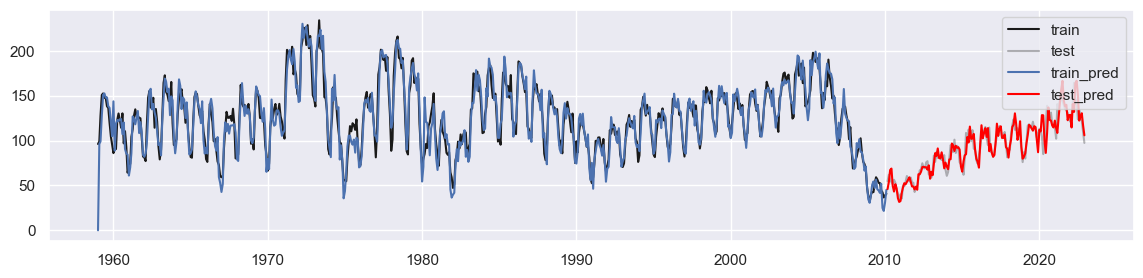

In [195]:
train_pred, test_pred = arima_model(train1['ts'], test1['ts'], orders=(1, 1, 0), seasonal=(1, 1, 0, 12), rolling=True)

train1['pred_arima'] = train_pred
test1['pred_arima'] = test_pred

# plot the results
plot_ts(train1, test1, train_pred, test_pred)


In [204]:
# print rmse on the train and test data
print('RMSE of ARIMA model on train data: {:.2f}'.format(rmse(train1.ts, train1['pred_arima'])))
print('RMSE of ARIMA model on test data: {:.2f}'.format(rmse(test1.ts, test1['pred_arima'])))

RMSE of ARIMA model on train data: 13.42
RMSE of ARIMA model on test data: 10.85


**For `train2`:**

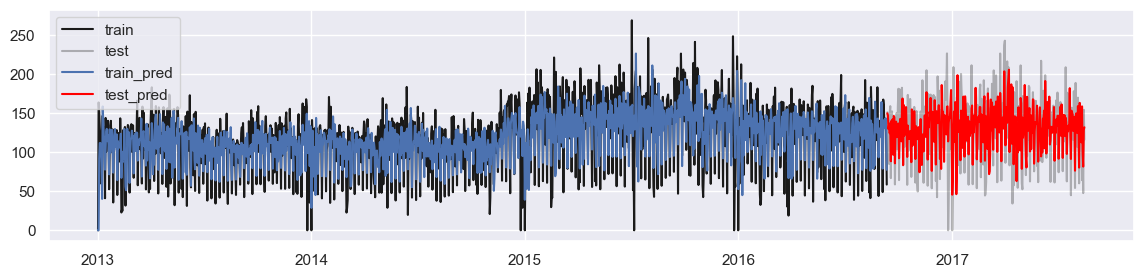

In [209]:
train_pred, test_pred = arima_model(train2['ts'], test2['ts'], orders=(2, 1, 1), seasonal=(1, 0, 0, 7), rolling=True)

train2['pred_arima'] = train_pred
test2['pred_arima'] = test_pred

# plot the results
plot_ts(train2, test2, train_pred, test_pred)

In [211]:
# print rmse on the train and test data
print('RMSE of ARIMA model on train data: {:.2f}'.format(rmse(train2.ts, train2['pred_arima'])))
print('RMSE of ARIMA model on test data: {:.2f}'.format(rmse(test2.ts, test2['pred_arima'])))

RMSE of ARIMA model on train data: 30.80
RMSE of ARIMA model on test data: 36.17


**For `train3`:**

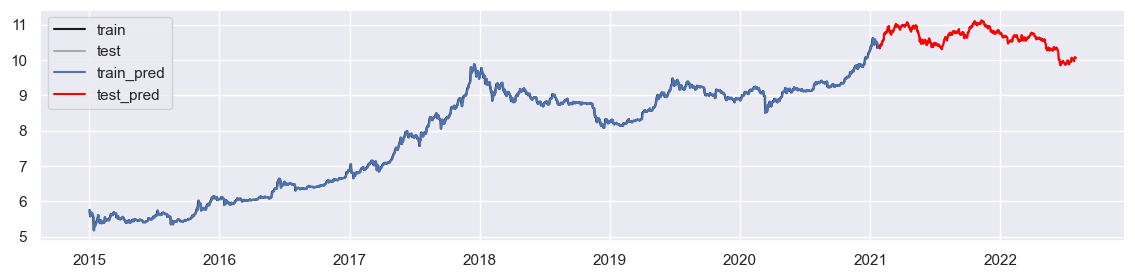

In [219]:
train_pred, test_pred = arima_model(train3['ts'], test3['ts'], orders=([6], 1, 0), seasonal=(0, 0, 0, 0), rolling=True)

train3['pred_arima'] = train_pred
test3['pred_arima'] = test_pred

# plot the results
plot_ts(train3[1:], test3[1:], train_pred[1:], test_pred[1:])

In [220]:
# print rmse on the train and test data
print('RMSE of ARIMA model on train data: {:.2f}'.format(rmse(train3.ts, train3['pred_arima'])))
print('RMSE of ARIMA model on test data: {:.2f}'.format(rmse(test3.ts, test3['pred_arima'])))

RMSE of ARIMA model on train data: 0.13
RMSE of ARIMA model on test data: 0.04


In [221]:
# saving train and test data
train1.to_csv('train1_pred.csv')
test1.to_csv('test1_pred.csv')
train2.to_csv('train2_pred.csv')
test2.to_csv('test2_pred.csv')
train3.to_csv('train3_pred.csv')
test3.to_csv('test3_pred.csv')

<a id='c7'></a>
## **5. Recurrent Neural Networks (RNN):**
Recurrent Neural Networks (RNNs) are a type of neural network that is designed to handle sequential data such as time-series data, speech signals, and natural language. The key feature of RNNs is the ability to selectively store and retrieve information from previous time steps. The structure of an RNN includes a hidden state that serves as the memory of the network and is updated at each time step. The input at each time step is combined with the previous hidden state to produce a new hidden state, which is then used to generate the output and update the hidden state at the next time step. This feedback loop allows RNNs to handle input sequences of arbitrary length and capture the temporal dependencies in the data. However, traditional RNNs suffer from the vanishing gradient problem, which limits their ability to handle long-term dependencies. This has led to the development of more sophisticated RNN architectures such as LSTMs and GRUs, which are designed to address this issue.

<img src=https://miro.medium.com/max/1400/1*ccHxugJhQo7VH4GAAZt3Sg.png width="600">

[Image Credit](https://pub.towardsai.net/whirlwind-tour-of-rnns-a11effb7808f)

In order to be able to develop the neural network-based models, we have to make sliding windows of the data with a certain `input length`, `output length`, and `lead time`. So, we define the following functions to generate the windows for all the three datasets. The generated windows will be used in all the next models.

**Note:** For more information on `sliding` and `expanding` windows, read [here](https://www.kaggle.com/code/cworsnup/backtesting-cross-validation-for-timeseries/notebook).

**Note:** Here, we use `sequential API` of the `Tensorflow Keras` to develop the models.

In [129]:
# define a function for making windows of data outputing inputs of lenght n and output of lenght m
def make_windows(data, in_length=5, out_length=1, target='ts'):
    X = []
    y = []
    for i in range(len(data)-in_length-out_length+1):
        X.append(data[i:i+in_length])
        y.append(data[[target]][i+in_length:i+in_length+out_length])
    return np.array(X), np.array(y)

Since here we do not have any additional features, we use past values of the time series together with seasonal indicators as the input features.

In [278]:
# define a function for making a dataset for the model
def make_dataset(df_train, df_test, in_length=5, out_length=1, batch_size=32, seasonal=True):
    # adding seasonal indicators to the train data 
    dp = DeterministicProcess(index=df_train.index,
                              constant=True,  # we add the constant to avoid an error when seasonal is False
                              order=0, 
                              drop=True, 
                              seasonal=seasonal)
    # use 'in_sample' to create features for the dates given in the 'index' argument
    df_trainfull = dp.in_sample().drop('const', axis=1)
    df_trainfull = pd.concat((df_trainfull, df_train[['ts']]), axis=1)
    df_trainfull.reset_index(drop=True, inplace=True)

    # adding seasonal indicators to the test data
    df_test = pd.concat((dp.out_of_sample(steps=len(df_test)).drop('const', axis=1), df_test[['ts']]), axis=1)
    df_test.reset_index(drop=True, inplace=True)

    # normalize the data
    scaler = MinMaxScaler()
    df_trainfull_nor = scaler.fit_transform(df_trainfull[['ts']])
    df_test_nor = scaler.transform(df_test[['ts']])

    # concatenate the normalized data with the seasonal indicators
    df_trainfull_nor = pd.concat((df_trainfull.drop('ts', axis=1), pd.DataFrame(df_trainfull_nor, columns=['ts'])), axis=1)
    df_test_nor = pd.concat((df_test.drop('ts', axis=1), pd.DataFrame(df_test_nor, columns=['ts'])), axis=1)

    # use 20% of the train data for validation
    df_train_nor, df_val_nor = train_test_split(df_trainfull_nor, test_size=0.2, shuffle=False)

    # making windows of input size of 12 and output size of 1
    X_train, y_train = make_windows(df_train_nor, in_length=in_length, out_length=out_length)
    X_val, y_val = make_windows(df_val_nor, in_length=in_length, out_length=out_length)
    X_test, y_test = make_windows(df_test_nor, in_length=in_length, out_length=out_length)
    X_trainfull, y_trainfull = make_windows(df_trainfull_nor, in_length=in_length, out_length=out_length)

    # make tensors of batch size 32 with tensorflow and shuffle the data
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(100).batch(batch_size)
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)
    trainfull_dataset = tf.data.Dataset.from_tensor_slices((X_trainfull, y_trainfull)).batch(batch_size)

    # print the shapes of the data
    print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape, X_trainfull.shape, y_trainfull.shape)
    return train_dataset, val_dataset, test_dataset, trainfull_dataset, scaler  

We generate the sliding windows for each dataset.

In [288]:
# make the datasets for train1, test1
train1_dataset, val1_dataset, test1_dataset, trainfull1_dataset, scaler1 = make_dataset(train1, test1, in_length=12, out_length=1, batch_size=32, seasonal=True) 

(479, 12, 12) (479, 1, 1) (111, 12, 12) (111, 1, 1) (142, 12, 12) (142, 1, 1) (602, 12, 12) (602, 1, 1)


In [261]:
# make the datasets for train2, test2
train2_dataset, val2_dataset, test2_dataset, trainfull2_dataset, scaler2 = make_dataset(train2, test2, in_length=7, out_length=1, batch_size=32, seasonal=True)

(1073, 7, 7) (1073, 1, 1) (263, 7, 7) (263, 1, 1) (331, 7, 7) (331, 1, 1) (1343, 7, 7) (1343, 1, 1)


In [281]:
# make the datasets for train3, test3
train3_dataset, val3_dataset, test3_dataset, trainfull3_dataset, scaler3 = make_dataset(train3, test3, in_length=50, out_length=1, batch_size=32, seasonal=False)

(1722, 50, 1) (1722, 1, 1) (394, 50, 1) (394, 1, 1) (504, 50, 1) (504, 1, 1) (2166, 50, 1) (2166, 1, 1)


We also define a function to compile and fit the models (which are all based on `Tensorflow Keras`.)

In [162]:
# define a function to compile and fit the models
def compile_and_fit(model, train_dataset, val_dataset, patience=5, epochs=100):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min',
                                                      restore_best_weights=True)
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=['mae', 'mse'])
    history = model.fit(train_dataset,
                        epochs=epochs,
                        validation_data=val_dataset,
                        callbacks=[early_stopping])
    return history

In [168]:
# define a function to plot the loss and metrics
def plot_loss(history):
    plt.figure(figsize=(6, 3))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

**For `train1`:**

4/4 [==============================] - 0s 7ms/step - loss: 0.0040 - mae: 0.0510 - mse: 0.0040
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 12, 32)            1440      
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 12, 32)            2080      
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_24 (Dense)            (None, 1)                 33        
                                                                 
 reshape_23 (Reshape)        (None, 1, 1)              0         
                                                                 
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_______________________

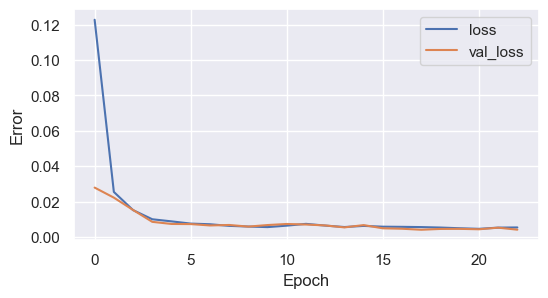

In [327]:
# make an RNN model for train1
model1 = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=(12, 12), return_sequences=True),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Reshape([1, 1])
])

# compile and fit the model
history1 = compile_and_fit(model1, train1_dataset, val1_dataset)
IPython.display.clear_output()

# performance of the model on train and validation data
model1.evaluate(train1_dataset)
model1.evaluate(val1_dataset)

# summary of the model
model1.summary()

# plot the loss and metrics
plot_loss(history1)

5/5 [==============================] - 0s 8ms/step


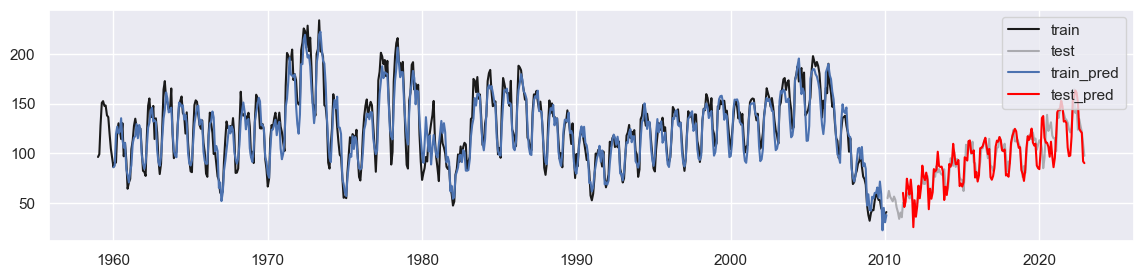

In [328]:
# make predictions on trainfull1 data and test data
train_pred1 = model1.predict(trainfull1_dataset) 
test_pred1 = model1.predict(test1_dataset)

# inverse transform the predictions based on min and max of df_train
train_pred1 = scaler1.inverse_transform(train_pred1.reshape(-1, 1))
test_pred1 = scaler1.inverse_transform(test_pred1.reshape(-1, 1))

# add the predictions to the train and test data considering the window size
train1['pred_rnn'] = np.nan
train1['pred_rnn'].iloc[12:] = train_pred1.reshape(-1)
test1['pred_rnn'] = np.nan
test1['pred_rnn'].iloc[12:] = test_pred1.reshape(-1)

# plot the predictions and actual values using plot_ts function
plot_ts(train1, test1, train1['pred_rnn'], test1['pred_rnn'])

In [329]:
# print rmse on the train and test data
print('RMSE of RNN model on train data: {:.2f}'.format(rmse(train1[12:].ts, train1['pred_rnn'][12:])))
print('RMSE of RNN model on test data: {:.2f}'.format(rmse(test1[12:].ts, test1['pred_rnn'][12:])))

RMSE of RNN model on train data: 13.15
RMSE of RNN model on test data: 12.77


**For `train2`:**

 1/34 [..............................] - ETA: 0s - loss: 0.0111 - mae: 0.0900 - mse: 0.0111

9/9 [==============================] - 0s 4ms/step - loss: 0.0132 - mae: 0.0738 - mse: 0.0132
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_12 (SimpleRNN)   (None, 7, 32)             1280      
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 7, 32)             2080      
                                                                 
 simple_rnn_14 (SimpleRNN)   (None, 32)                2080      
                                                                 
 dense_26 (Dense)            (None, 1)                 33        
                                                                 
 reshape_25 (Reshape)        (None, 1, 1)              0         
                                                                 
Total params: 5,473
Trainable params: 5,473
Non-trainable params: 0
_______________________

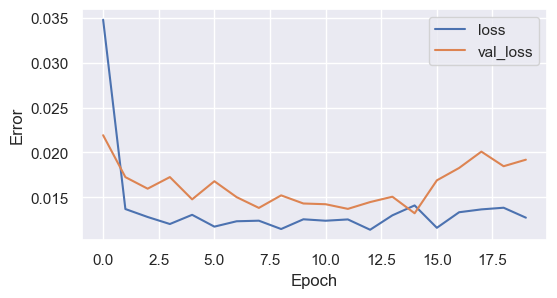

In [331]:
# make an RNN model for train2
model2 = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=(7, 7), return_sequences=True),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Reshape([1, 1])
])

# compile and fit the model
history2 = compile_and_fit(model2, train2_dataset, val2_dataset)
IPython.display.clear_output()

# performance of the model on train and validation data
model2.evaluate(train2_dataset)
model2.evaluate(val2_dataset)

# summary of the model
model2.summary()

# plot the loss and metrics
plot_loss(history2)

11/11 [==============================] - 0s 4ms/step


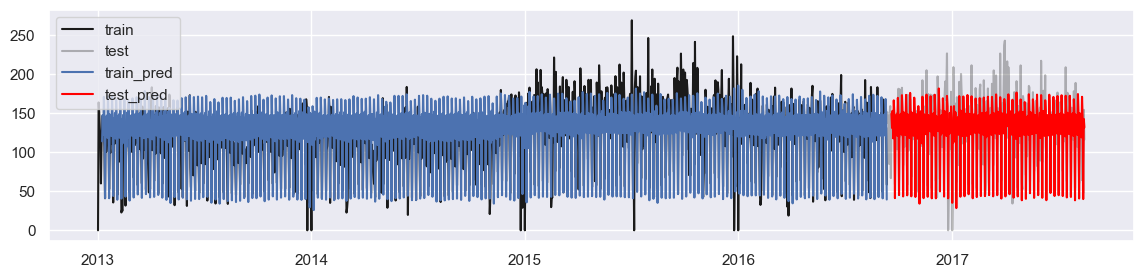

In [332]:
# make predictions on trainfull2 data and test data
train_pred2 = model2.predict(trainfull2_dataset)
test_pred2 = model2.predict(test2_dataset)

# inverse transform the predictions based on min and max of df_train
train_pred2 = scaler2.inverse_transform(train_pred2.reshape(-1, 1))
test_pred2 = scaler2.inverse_transform(test_pred2.reshape(-1, 1))

# add the predictions to the train and test data considering the window size
train2['pred_rnn'] = np.nan
train2['pred_rnn'].iloc[7:] = train_pred2.reshape(-1)
test2['pred_rnn'] = np.nan
test2['pred_rnn'].iloc[7:] = test_pred2.reshape(-1)

# plot the predictions and actual values using plot_ts function
plot_ts(train2, test2, train2['pred_rnn'], test2['pred_rnn'])

In [333]:
# print rmse on the train and test data
print('RMSE of RNN model on train data: {:.2f}'.format(rmse(train2[7:].ts, train2['pred_rnn'][7:])))
print('RMSE of RNN model on test data: {:.2f}'.format(rmse(test2[7:].ts, test2['pred_rnn'][7:])))


RMSE of RNN model on train data: 32.48
RMSE of RNN model on test data: 30.35


**For `train3`:**

13/13 [==============================] - 0s 15ms/step - loss: 3.5544e-04 - mae: 0.0120 - mse: 3.5544e-04
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_15 (SimpleRNN)   (None, 50, 32)            1088      
                                                                 
 simple_rnn_16 (SimpleRNN)   (None, 50, 32)            2080      
                                                                 
 simple_rnn_17 (SimpleRNN)   (None, 32)                2080      
                                                                 
 dense_27 (Dense)            (None, 1)                 33        
                                                                 
 reshape_26 (Reshape)        (None, 1, 1)              0         
                                                                 
Total params: 5,281
Trainable params: 5,281
Non-trainable params: 0
____________

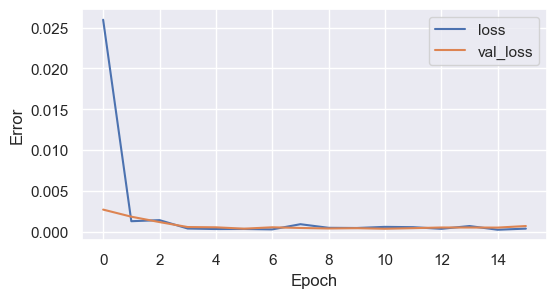

In [334]:
# make an RNN model for train3
model3 = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=(50, 1), return_sequences=True),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Reshape([1, 1])
])

# compile and fit the model
history3 = compile_and_fit(model3, train3_dataset, val3_dataset)
IPython.display.clear_output()

# performance of the model on train and validation data
model3.evaluate(train3_dataset)
model3.evaluate(val3_dataset)

# summary of the model
model3.summary()

# plot the loss and metrics
plot_loss(history3)

16/16 [==============================] - 0s 12ms/step


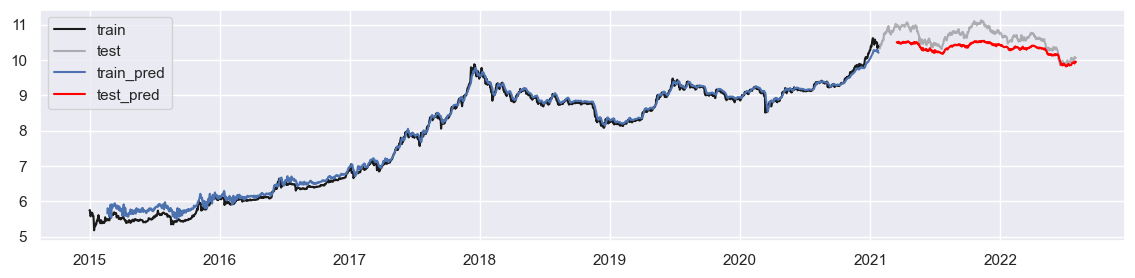

In [335]:
# make predictions on trainfull3 data and test data
train_pred3 = model3.predict(trainfull3_dataset)
test_pred3 = model3.predict(test3_dataset)

# inverse transform the predictions based on min and max of df_train
train_pred3 = scaler3.inverse_transform(train_pred3.reshape(-1, 1))
test_pred3 = scaler3.inverse_transform(test_pred3.reshape(-1, 1))

# add the predictions to the train and test data considering the window size
train3['pred_rnn'] = np.nan
train3['pred_rnn'].iloc[50:] = train_pred3.reshape(-1)
test3['pred_rnn'] = np.nan
test3['pred_rnn'].iloc[50:] = test_pred3.reshape(-1)

# plot the predictions and actual values using plot_ts function
plot_ts(train3, test3, train3['pred_rnn'], test3['pred_rnn'])

In [336]:
# print rmse on the train and test data
print('RMSE of RNN model on train data: {:.2f}'.format(rmse(train3[50:].ts, train3['pred_rnn'][50:])))
print('RMSE of RNN model on test data: {:.2f}'.format(rmse(test3[50:].ts, test3['pred_rnn'][50:])))

RMSE of RNN model on train data: 0.12
RMSE of RNN model on test data: 0.33


<a id='c8'></a>
## **6. Long Short-Term Memory (LSTM) Networks:**
Long Short-Term Memory (LSTM) networks are a type of recurrent neural network (RNN) that is widely used in sequential data modeling tasks. LSTM networks are designed to overcome the limitations of traditional RNNs, which suffer from the vanishing gradient problem when dealing with long sequences. LSTMs are capable of selectively retaining or forgetting information over longer periods of time, making them particularly useful when modeling sequential data with long-term dependencies.

The structure of an LSTM network is more complex than that of a traditional RNN and includes several additional components. In addition to the input and output layers, an LSTM network also includes a memory cell and three gates: the input gate, the forget gate, and the output gate. The memory cell is responsible for storing and retrieving information over longer periods of time. The input gate controls how much new information should be added to the memory cell, while the forget gate controls how much old information should be discarded. The output gate then determines how much of the updated memory cell should be passed on to the next time step. The use of these gates allows LSTMs to selectively store or discard information from the previous time step, making them particularly useful for modeling sequential data with long-term dependencies.

<img src=https://miro.medium.com/max/1400/1*Zrht4QBK5_hAxif17ED4ew.png width="500">

[Image Credit](https://towardsdatascience.com/lstm-recurrent-neural-networks-how-to-teach-a-network-to-remember-the-past-55e54c2ff22e)

<a id='c81'></a>
### **6.1 Vanilla LSTM:**
A Vanilla LSTM is an LSTM model that has a single hidden layer of LSTM units, and an output layer used to make a prediction. [[ref]](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/#:~:text=A%20Vanilla%20LSTM%20is%20an,time%20series%20forecasting%20as%20follows.)

<img src=https://miro.medium.com/max/659/1*ZwpFITgrSf9W2RuDLj6dXw.jpeg width="500">

[Image Credit](https://medium.datadriveninvestor.com/text-prediction-using-long-short-term-memory-a42fc66e22c3?gi=0d7996a04888)

**For `train1`:**

 1/15 [=>............................] - ETA: 0s - loss: 0.0035 - mae: 0.0453 - mse: 0.0035

4/4 [==============================] - 0s 6ms/step - loss: 0.0055 - mae: 0.0598 - mse: 0.0055
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 32)                5888      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
 reshape_3 (Reshape)         (None, 1, 1)              0         
                                                                 
Total params: 5,921
Trainable params: 5,921
Non-trainable params: 0
_________________________________________________________________


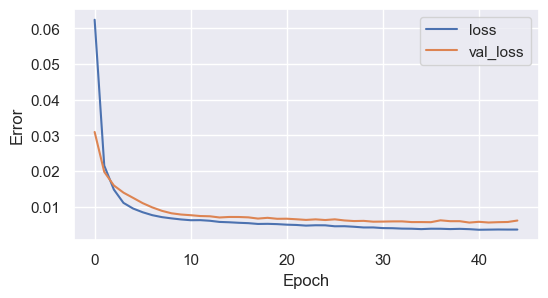

In [219]:
# make a vanilla LSTM model for train1
model1 = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, input_shape=(12, 12), return_sequences=False),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Reshape([1, 1])
])

# fit the model
history1 = compile_and_fit(model1, train1_dataset, val1_dataset)
IPython.display.clear_output()

# performance of the model on train and validation data
model1.evaluate(train1_dataset)
model1.evaluate(val1_dataset)

# summary of the model
model1.summary()

# plot the loss and validation loss
plot_loss(history1)

5/5 [==============================] - 0s 5ms/step


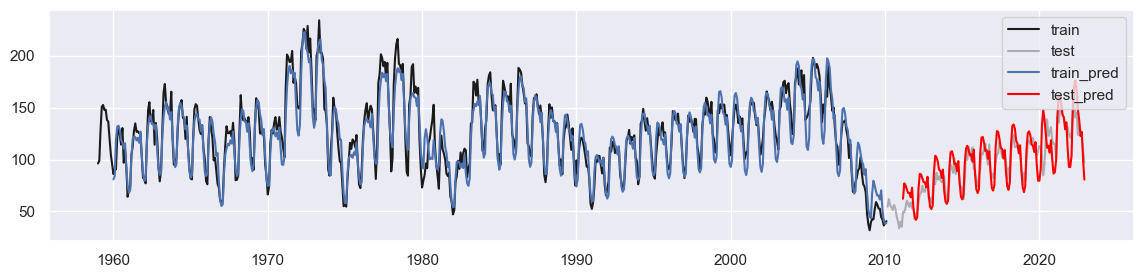

In [220]:
# make predictions on trainfull1 data and test data
train_pred1 = model1.predict(trainfull1_dataset) 
test_pred1 = model1.predict(test1_dataset)

# inverse transform the predictions based on min and max of df_train
train_pred1 = scaler1.inverse_transform(train_pred1.reshape(-1, 1))
test_pred1 = scaler1.inverse_transform(test_pred1.reshape(-1, 1))

# add the predictions to the train and test data considering the window size
train1['pred_lstm_vanilla'] = np.nan
train1['pred_lstm_vanilla'].iloc[12:] = train_pred1.reshape(-1)
test1['pred_lstm_vanilla'] = np.nan
test1['pred_lstm_vanilla'].iloc[12:] = test_pred1.reshape(-1)

# plot the predictions and actual values using plot_ts function
plot_ts(train1, test1, train1['pred_lstm_vanilla'], test1['pred_lstm_vanilla'])

In [221]:
# print rmse on the train and test data
print('RMSE of vanilla LSTM model on train data: {:.2f}'.format(rmse(train1[12:].ts, train1['pred_lstm_vanilla'][12:])))
print('RMSE of vanilla LSTM model on test data: {:.2f}'.format(rmse(test1[12:].ts, test1['pred_lstm_vanilla'][12:])))

RMSE of vanilla LSTM model on train data: 12.59
RMSE of vanilla LSTM model on test data: 14.99


**For `train2`:**

9/9 [==============================] - 0s 5ms/step - loss: 0.0135 - mae: 0.0779 - mse: 0.0135
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 32)                5248      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
 reshape_5 (Reshape)         (None, 1, 1)              0         
                                                                 
Total params: 5,281
Trainable params: 5,281
Non-trainable params: 0
_________________________________________________________________


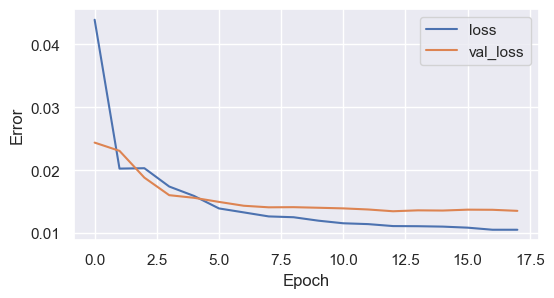

In [223]:
# make a vanilla LSTM model for train2
model2 = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, input_shape=(7, 7), return_sequences=False),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Reshape([1, 1])
])

# fit the model
history2 = compile_and_fit(model2, train2_dataset, val2_dataset)
IPython.display.clear_output()

# performance of the model on train and validation data
model2.evaluate(train2_dataset)
model2.evaluate(val2_dataset)

# summary of the model
model2.summary()

# plot the loss and validation loss
plot_loss(history2)

11/11 [==============================] - 0s 3ms/step


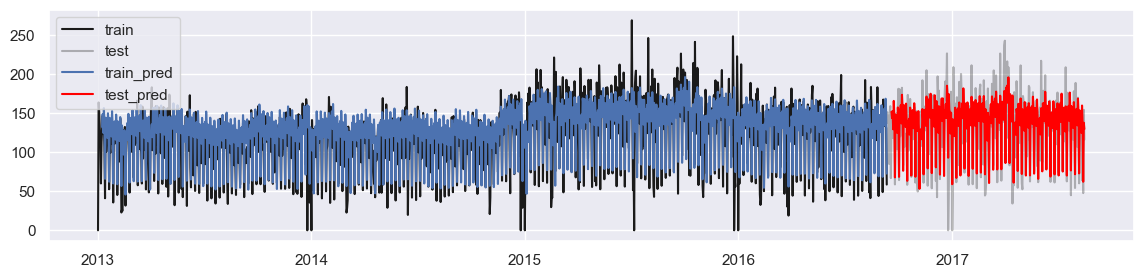

In [224]:
# make predictions on trainfull1 data and test data
train_pred2 = model2.predict(trainfull2_dataset)
test_pred2 = model2.predict(test2_dataset)

# inverse transform the predictions based on min and max of df_train
train_pred2 = scaler2.inverse_transform(train_pred2.reshape(-1, 1))
test_pred2 = scaler2.inverse_transform(test_pred2.reshape(-1, 1))

# add the predictions to the train and test data considering the window size
train2['pred_lstm_vanilla'] = np.nan
train2['pred_lstm_vanilla'].iloc[7:] = train_pred2.reshape(-1)
test2['pred_lstm_vanilla'] = np.nan
test2['pred_lstm_vanilla'].iloc[7:] = test_pred2.reshape(-1)

# plot the predictions and actual values using plot_ts function
plot_ts(train2, test2, train2['pred_lstm_vanilla'], test2['pred_lstm_vanilla'])

In [225]:
# print rmse on the train and test data
print('RMSE of vanilla LSTM model on train data: {:.2f}'.format(rmse(train2[7:].ts, train2['pred_lstm_vanilla'][7:])))
print('RMSE of vanilla LSTM model on test data: {:.2f}'.format(rmse(test2[7:].ts, test2['pred_lstm_vanilla'][7:])))

RMSE of vanilla LSTM model on train data: 29.35
RMSE of vanilla LSTM model on test data: 31.14


**For `train3`:**

13/13 [==============================] - 0s 17ms/step - loss: 4.2181e-04 - mae: 0.0135 - mse: 4.2181e-04
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 32)                4352      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
 reshape_7 (Reshape)         (None, 1, 1)              0         
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


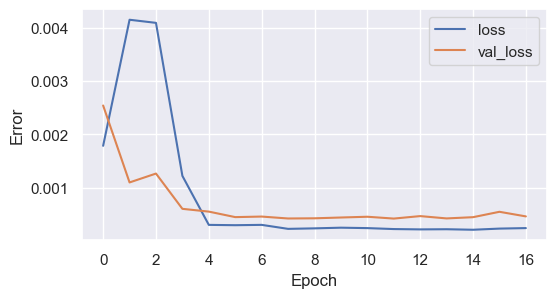

In [282]:
# make a vanilla LSTM model for train3
model3 = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, input_shape=(50, 1), return_sequences=False),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Reshape([1, 1])
])

# fit the model
history3 = compile_and_fit(model3, train3_dataset, val3_dataset)
IPython.display.clear_output()

# performance of the model on train and validation data
model3.evaluate(train3_dataset)
model3.evaluate(val3_dataset)

# summary of the model
model3.summary()

# plot the loss and validation loss
plot_loss(history3)

16/16 [==============================] - 0s 18ms/step


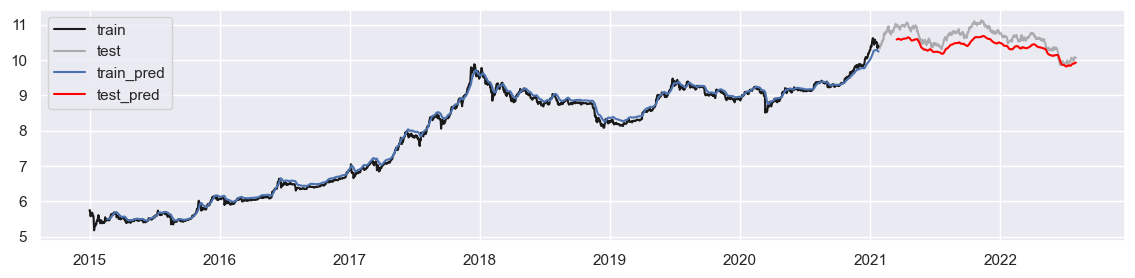

In [284]:
# make predictions on trainfull1 data and test data
train_pred3 = model3.predict(trainfull3_dataset)
test_pred3 = model3.predict(test3_dataset)

# inverse transform the predictions based on min and max of df_train
train_pred3 = scaler3.inverse_transform(train_pred3.reshape(-1, 1))
test_pred3 = scaler3.inverse_transform(test_pred3.reshape(-1, 1))

# add the predictions to the train and test data considering the window size
train3['pred_lstm_vanilla'] = np.nan
train3['pred_lstm_vanilla'].iloc[50:] = train_pred3.reshape(-1)
test3['pred_lstm_vanilla'] = np.nan
test3['pred_lstm_vanilla'].iloc[50:] = test_pred3.reshape(-1)

# plot the predictions and actual values using plot_ts function
plot_ts(train3, test3, train3['pred_lstm_vanilla'], test3['pred_lstm_vanilla'])

In [285]:
# print rmse on the train and test data
print('RMSE of vanilla LSTM model on train data: {:.2f}'.format(rmse(train3[50:].ts, train3['pred_lstm_vanilla'][50:])))
print('RMSE of vanilla LSTM model on test data: {:.2f}'.format(rmse(test3[50:].ts, test3['pred_lstm_vanilla'][50:])))

RMSE of vanilla LSTM model on train data: 0.10
RMSE of vanilla LSTM model on test data: 0.28


<a id='c82'></a>
### **6.2 Stacked LSTM:**
The stacked LSTM is an extension to this model that has multiple hidden LSTM layers where each layer contains multiple memory cells. 7. The stacked LSTM hidden layers make the model deeper, more accurately earning the description as a deep learning technique. [[ref]](https://aapm.onlinelibrary.wiley.com/doi/full/10.1002/acm2.13558#:~:text=The%20stacked%20LSTM%20is%20an,as%20a%20deep%20learning%20technique.)


<img src=https://i.stack.imgur.com/TtfMs.jpg width="400">

[Image Credit](https://datascience.stackexchange.com/questions/40171/stacking-lstm-layers)

**For `train1`:**

 1/15 [=>............................] - ETA: 0s - loss: 0.0045 - mae: 0.0524 - mse: 0.0045

4/4 [==============================] - 0s 5ms/step - loss: 0.0077 - mae: 0.0726 - mse: 0.0077
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 12, 32)            5760      
                                                                 
 lstm_13 (LSTM)              (None, 32)                8320      
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
 reshape_10 (Reshape)        (None, 1, 1)              0         
                                                                 
Total params: 14,113
Trainable params: 14,113
Non-trainable params: 0
_________________________________________________________________


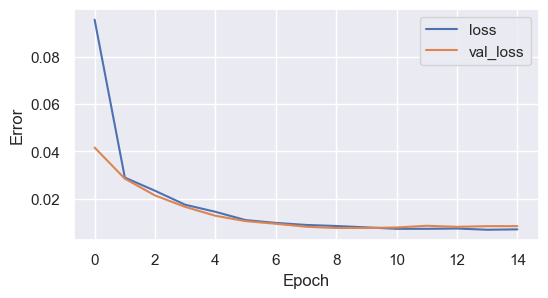

In [291]:
# make a stacked LSTM model for train1
model1 = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, input_shape=(12, 12), return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Reshape([1, 1])
])

# fit the model
history1 = compile_and_fit(model1, train1_dataset, val1_dataset)
IPython.display.clear_output()

# performance of the model on train and validation data
model1.evaluate(train1_dataset)
model1.evaluate(val1_dataset)

# summary of the model
model1.summary()

# plot the loss and validation loss
plot_loss(history1)

5/5 [==============================] - 0s 4ms/step


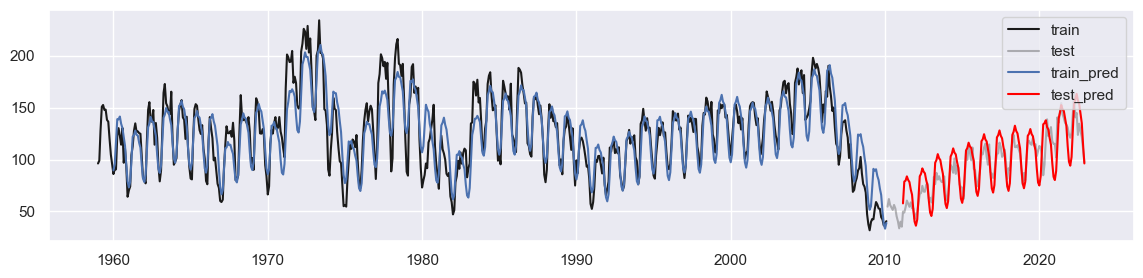

In [292]:
# make predictions on trainfull1 data and test data
train_pred1 = model1.predict(trainfull1_dataset)
test_pred1 = model1.predict(test1_dataset)

# inverse transform the predictions based on min and max of df_train
train_pred1 = scaler1.inverse_transform(train_pred1.reshape(-1, 1))
test_pred1 = scaler1.inverse_transform(test_pred1.reshape(-1, 1))

# add the predictions to the train and test data considering the window size
train1['pred_lstm_stacked'] = np.nan
train1['pred_lstm_stacked'].iloc[12:] = train_pred1.reshape(-1)
test1['pred_lstm_stacked'] = np.nan
test1['pred_lstm_stacked'].iloc[12:] = test_pred1.reshape(-1)

# plot the predictions and actual values using plot_ts function
plot_ts(train1, test1, train1['pred_lstm_stacked'], test1['pred_lstm_stacked'])

In [293]:
# print rmse on the train and test data
print('RMSE of stacked LSTM model on train data: {:.2f}'.format(rmse(train1[12:].ts, train1['pred_lstm_stacked'][12:])))
print('RMSE of stacked LSTM model on test data: {:.2f}'.format(rmse(test1[12:].ts, test1['pred_lstm_stacked'][12:])))

RMSE of stacked LSTM model on train data: 17.33
RMSE of stacked LSTM model on test data: 15.31


**For `train2`:**

9/9 [==============================] - 0s 6ms/step - loss: 0.0178 - mae: 0.0962 - mse: 0.0178
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 7, 32)             5120      
                                                                 
 lstm_15 (LSTM)              (None, 32)                8320      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
 reshape_11 (Reshape)        (None, 1, 1)              0         
                                                                 
Total params: 13,473
Trainable params: 13,473
Non-trainable params: 0
_________________________________________________________________


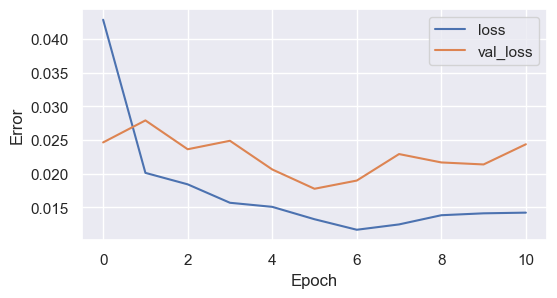

In [294]:
# make a stacked LSTM model for train2
model2 = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, input_shape=(7, 7), return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Reshape([1, 1])
])

# fit the model
history2 = compile_and_fit(model2, train2_dataset, val2_dataset)
IPython.display.clear_output()

# performance of the model on train and validation data
model2.evaluate(train2_dataset)
model2.evaluate(val2_dataset)

# summary of the model
model2.summary()

# plot the loss and validation loss
plot_loss(history2)

11/11 [==============================] - 0s 3ms/step


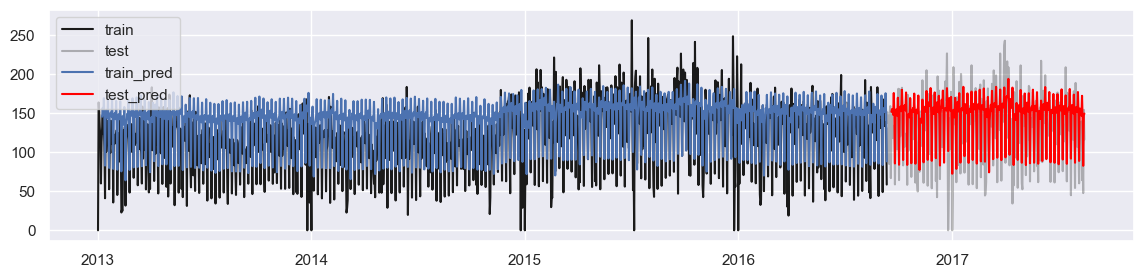

In [295]:
# make predictions on trainfull2 data and test data
train_pred2 = model2.predict(trainfull2_dataset)
test_pred2 = model2.predict(test2_dataset)

# inverse transform the predictions based on min and max of df_train
train_pred2 = scaler2.inverse_transform(train_pred2.reshape(-1, 1))
test_pred2 = scaler2.inverse_transform(test_pred2.reshape(-1, 1))

# add the predictions to the train and test data considering the window size
train2['pred_lstm_stacked'] = np.nan
train2['pred_lstm_stacked'].iloc[7:] = train_pred2.reshape(-1)
test2['pred_lstm_stacked'] = np.nan
test2['pred_lstm_stacked'].iloc[7:] = test_pred2.reshape(-1)

# plot the predictions and actual values using plot_ts function
plot_ts(train2, test2, train2['pred_lstm_stacked'], test2['pred_lstm_stacked'])

In [296]:
# print rmse on the train and test data
print('RMSE of stacked LSTM model on train data: {:.2f}'.format(rmse(train2[7:].ts, train2['pred_lstm_stacked'][7:])))
print('RMSE of stacked LSTM model on test data: {:.2f}'.format(rmse(test2[7:].ts, test2['pred_lstm_stacked'][7:])))

RMSE of stacked LSTM model on train data: 36.63
RMSE of stacked LSTM model on test data: 34.31


**For `train3`:**

 1/54 [..............................] - ETA: 1s - loss: 9.8941e-05 - mae: 0.0078 - mse: 9.8941e-05

13/13 [==============================] - 0s 27ms/step - loss: 2.0949e-04 - mae: 0.0096 - mse: 2.0949e-04
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 50, 32)            4352      
                                                                 
 lstm_17 (LSTM)              (None, 32)                8320      
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
 reshape_12 (Reshape)        (None, 1, 1)              0         
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


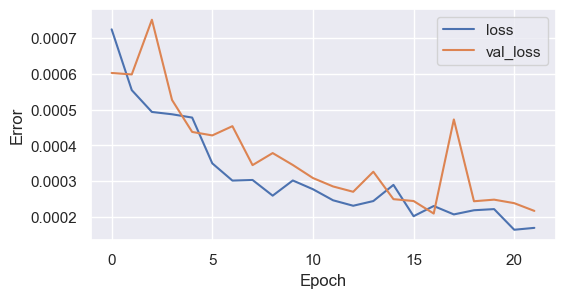

In [297]:
# make a stacked LSTM model for train3
model3 = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, input_shape=(50, 1), return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Reshape([1, 1])
])

# fit the model
history3 = compile_and_fit(model3, train3_dataset, val3_dataset)
IPython.display.clear_output()

# performance of the model on train and validation data
model3.evaluate(train3_dataset)
model3.evaluate(val3_dataset)

# summary of the model
model3.summary()

# plot the loss and validation loss
plot_loss(history3)

16/16 [==============================] - 0s 28ms/step


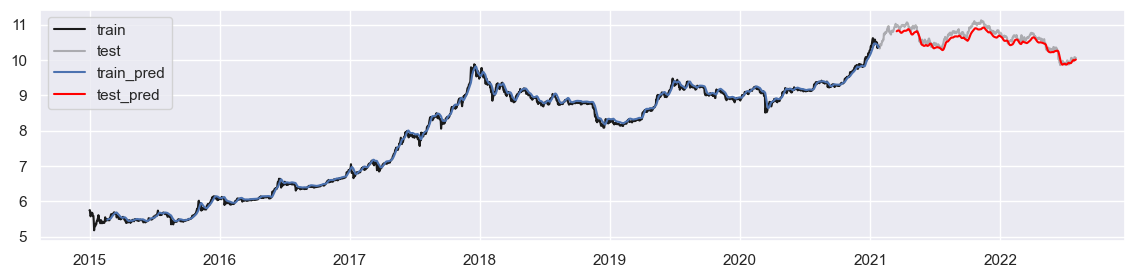

In [298]:
# make predictions on trainfull3 data and test data
train_pred3 = model3.predict(trainfull3_dataset)
test_pred3 = model3.predict(test3_dataset)

# inverse transform the predictions based on min and max of df_train
train_pred3 = scaler3.inverse_transform(train_pred3.reshape(-1, 1))
test_pred3 = scaler3.inverse_transform(test_pred3.reshape(-1, 1))

# add the predictions to the train and test data considering the window size
train3['pred_lstm_stacked'] = np.nan
train3['pred_lstm_stacked'].iloc[50:] = train_pred3.reshape(-1)
test3['pred_lstm_stacked'] = np.nan
test3['pred_lstm_stacked'].iloc[50:] = test_pred3.reshape(-1)

# plot the predictions and actual values using plot_ts function
plot_ts(train3, test3, train3['pred_lstm_stacked'], test3['pred_lstm_stacked'])

In [299]:
# print rmse on the train and test data
print('RMSE of stacked LSTM model on train data: {:.2f}'.format(rmse(train3[50:].ts, train3['pred_lstm_stacked'][50:])))
print('RMSE of stacked LSTM model on test data: {:.2f}'.format(rmse(test3[50:].ts, test3['pred_lstm_stacked'][50:])))

RMSE of stacked LSTM model on train data: 0.08
RMSE of stacked LSTM model on test data: 0.12


<a id='c83'></a>
### **6.3 Bidirectional LSTM:**
In summary, BiLSTM adds one more LSTM layer, which reverses the direction of information flow. Briefly, it means that the input sequence flows backward in the additional LSTM layer. Then we combine the outputs from both LSTM layers in several ways, such as average, sum, multiplication, or concatenation. [[ref]](https://www.baeldung.com/cs/bidirectional-vs-unidirectional-lstm#:~:text=Bidirectional%20LSTM%20(BiLSTM)%20is%20a,utilizing%20information%20from%20both%20sides.)

<img src=http://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/f7bdb849dafe17c952bfd88b879e01f74cf59d78/4-Figure3-1.png width="600">

[Image Credit](http://www.gabormelli.com/RKB/Bidirectional_Recurrent_Neural_Network_%28BiRNN%29)

**For `train1`:**

 1/15 [=>............................] - ETA: 0s - loss: 0.0032 - mae: 0.0435 - mse: 0.0032

4/4 [==============================] - 0s 9ms/step - loss: 0.0049 - mae: 0.0575 - mse: 0.0049
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 64)               11520     
 nal)                                                            
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
 reshape_14 (Reshape)        (None, 1, 1)              0         
                                                                 
Total params: 11,585
Trainable params: 11,585
Non-trainable params: 0
_________________________________________________________________


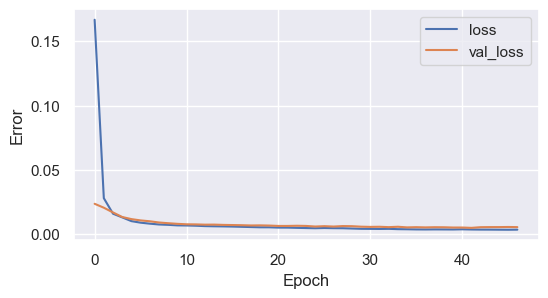

In [302]:
# make a bidirectional LSTM model for train1
model1 = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, input_shape=(12, 12))),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Reshape([1, 1])
])

# fit the model
history1 = compile_and_fit(model1, train1_dataset, val1_dataset)
IPython.display.clear_output()

# performance of the model on train and validation data
model1.evaluate(train1_dataset)
model1.evaluate(val1_dataset)

# summary of the model
model1.summary()

# plot the loss and validation loss
plot_loss(history1)

5/5 [==============================] - 0s 4ms/step


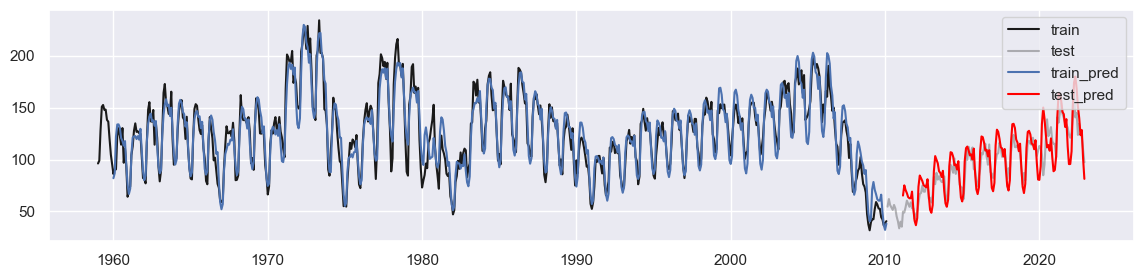

In [303]:
# make predictions on trainfull1 data and test data
train_pred1 = model1.predict(trainfull1_dataset)
test_pred1 = model1.predict(test1_dataset)

# inverse transform the predictions based on min and max of df_train
train_pred1 = scaler1.inverse_transform(train_pred1.reshape(-1, 1))
test_pred1 = scaler1.inverse_transform(test_pred1.reshape(-1, 1))

# add the predictions to the train and test data considering the window size
train1['pred_lstm_bidirectional'] = np.nan
train1['pred_lstm_bidirectional'].iloc[12:] = train_pred1.reshape(-1)
test1['pred_lstm_bidirectional'] = np.nan
test1['pred_lstm_bidirectional'].iloc[12:] = test_pred1.reshape(-1)

# plot the predictions and actual values using plot_ts function
plot_ts(train1, test1, train1['pred_lstm_bidirectional'], test1['pred_lstm_bidirectional'])

In [304]:
# print rmse on the train and test data
print('RMSE of bidirectional LSTM model on train data: {:.2f}'.format(rmse(train1[12:].ts, train1['pred_lstm_bidirectional'][12:])))
print('RMSE of bidirectional LSTM model on test data: {:.2f}'.format(rmse(test1[12:].ts, test1['pred_lstm_bidirectional'][12:])))

RMSE of bidirectional LSTM model on train data: 12.16
RMSE of bidirectional LSTM model on test data: 14.91


**For `train2`:**

 1/34 [..............................] - ETA: 0s - loss: 0.0109 - mae: 0.0764 - mse: 0.0109

9/9 [==============================] - 0s 5ms/step - loss: 0.0129 - mae: 0.0755 - mse: 0.0129
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 64)               10240     
 nal)                                                            
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
 reshape_15 (Reshape)        (None, 1, 1)              0         
                                                                 
Total params: 10,305
Trainable params: 10,305
Non-trainable params: 0
_________________________________________________________________


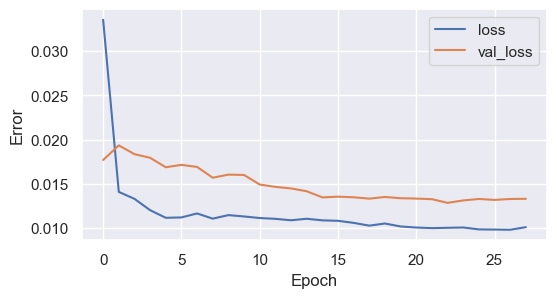

In [305]:
# make a bidirectional LSTM model for train2
model2 = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, input_shape=(7, 7))),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Reshape([1, 1])
])

# fit the model
history2 = compile_and_fit(model2, train2_dataset, val2_dataset)
IPython.display.clear_output()

# performance of the model on train and validation data
model2.evaluate(train2_dataset)
model2.evaluate(val2_dataset)

# summary of the model
model2.summary()

# plot the loss and validation loss
plot_loss(history2)

11/11 [==============================] - 0s 3ms/step


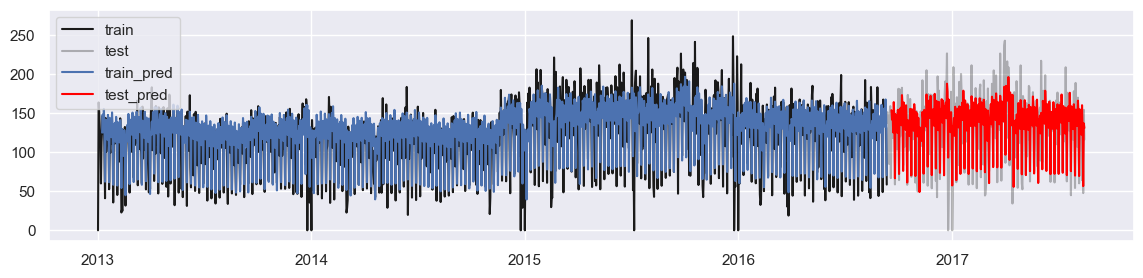

In [306]:
# make predictions on trainfull2 data and test data
train_pred2 = model2.predict(trainfull2_dataset)
test_pred2 = model2.predict(test2_dataset)

# inverse transform the predictions based on min and max of df_train
train_pred2 = scaler2.inverse_transform(train_pred2.reshape(-1, 1))
test_pred2 = scaler2.inverse_transform(test_pred2.reshape(-1, 1))

# add the predictions to the train and test data considering the window size
train2['pred_lstm_bidirectional'] = np.nan
train2['pred_lstm_bidirectional'].iloc[7:] = train_pred2.reshape(-1)
test2['pred_lstm_bidirectional'] = np.nan
test2['pred_lstm_bidirectional'].iloc[7:] = test_pred2.reshape(-1)

# plot the predictions and actual values using plot_ts function
plot_ts(train2, test2, train2['pred_lstm_bidirectional'], test2['pred_lstm_bidirectional'])

In [307]:
# print rmse on the train and test data
print('RMSE of bidirectional LSTM model on train data: {:.2f}'.format(rmse(train2[7:].ts, train2['pred_lstm_bidirectional'][7:])))
print('RMSE of bidirectional LSTM model on test data: {:.2f}'.format(rmse(test2[7:].ts, test2['pred_lstm_bidirectional'][7:])))

RMSE of bidirectional LSTM model on train data: 28.27
RMSE of bidirectional LSTM model on test data: 30.67


**For `train3`:**

 1/54 [..............................] - ETA: 1s - loss: 0.0095 - mae: 0.0965 - mse: 0.0095

13/13 [==============================] - 0s 18ms/step - loss: 0.0013 - mae: 0.0264 - mse: 0.0013   
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 64)               8704      
 nal)                                                            
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
 reshape_17 (Reshape)        (None, 1, 1)              0         
                                                                 
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________


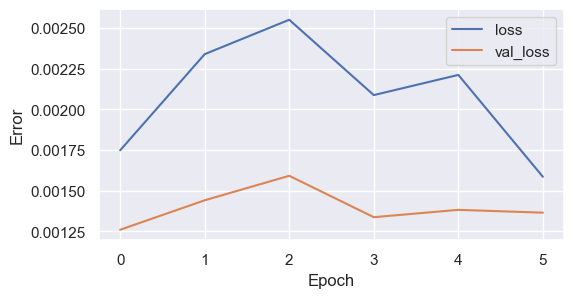

In [309]:
# make a bidirectional LSTM model for train3
model3 = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, input_shape=(50, 1))),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Reshape([1, 1])
])

# fit the model
history3 = compile_and_fit(model3, train3_dataset, val3_dataset)
IPython.display.clear_output()

# performance of the model on train and validation data
model3.evaluate(train3_dataset)
model3.evaluate(val3_dataset)

# summary of the model
model3.summary()

# plot the loss and validation loss
plot_loss(history3)

16/16 [==============================] - 0s 9ms/step


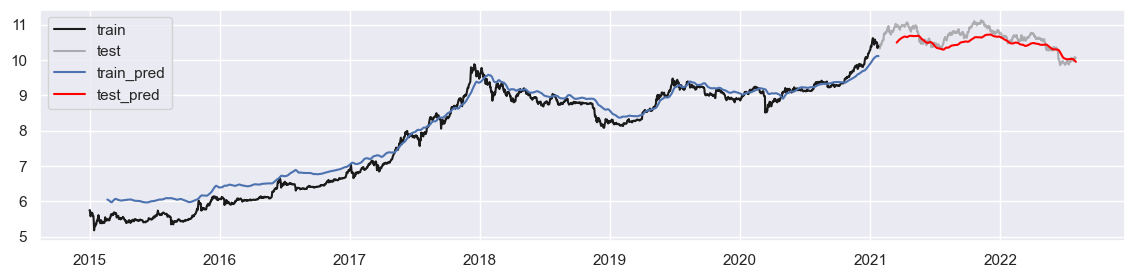

In [310]:
# make predictions on trainfull3 data and test data
train_pred3 = model3.predict(trainfull3_dataset)
test_pred3 = model3.predict(test3_dataset)

# inverse transform the predictions based on min and max of df_train
train_pred3 = scaler3.inverse_transform(train_pred3.reshape(-1, 1))
test_pred3 = scaler3.inverse_transform(test_pred3.reshape(-1, 1))

# add the predictions to the train and test data considering the window size
train3['pred_lstm_bidirectional'] = np.nan
train3['pred_lstm_bidirectional'].iloc[50:] = train_pred3.reshape(-1)
test3['pred_lstm_bidirectional'] = np.nan
test3['pred_lstm_bidirectional'].iloc[50:] = test_pred3.reshape(-1)

# plot the predictions and actual values using plot_ts function
plot_ts(train3, test3, train3['pred_lstm_bidirectional'], test3['pred_lstm_bidirectional'])

In [311]:
# print rmse on the train and test data
print('RMSE of bidirectional LSTM model on train data: {:.2f}'.format(rmse(train3[50:].ts, train3['pred_lstm_bidirectional'][50:])))
print('RMSE of bidirectional LSTM model on test data: {:.2f}'.format(rmse(test3[50:].ts, test3['pred_lstm_bidirectional'][50:])))

RMSE of bidirectional LSTM model on train data: 0.29
RMSE of bidirectional LSTM model on test data: 0.23


In [323]:
# saving train and test data
train1.to_csv('train1_pred.csv')
test1.to_csv('test1_pred.csv')
train2.to_csv('train2_pred.csv')
test2.to_csv('test2_pred.csv')
train3.to_csv('train3_pred.csv')
test3.to_csv('test3_pred.csv')

<a id='c9'></a>
## **7. Gated Recurrent Unit (GRU):**

Gated Recurrent Units (GRUs) are a type of recurrent neural network (RNN) that is widely used in sequential data modeling tasks. GRUs are similar to Long Short-Term Memory (LSTM) networks in that they also have a mechanism to selectively retain or discard information. However, GRUs are simpler and more computationally efficient than LSTMs, which makes them more suitable for smaller datasets or real-time applications. GRUs are particularly useful when dealing with long-term dependencies in sequential data because they can selectively store important information over longer periods of time.

The structure of a GRU is relatively simple and consists of two gates: the reset gate and the update gate. These gates control how much of the previous state and the current input should be retained or discarded. The reset gate determines how much of the previous state should be forgotten, while the update gate decides how much of the current input should be stored. The use of these gates allows GRUs to selectively retain or discard information from the previous time step, making them particularly useful for modeling sequential data with long-term dependencies.

<img src=https://miro.medium.com/max/1400/1*3a8HnDUlzhhKcSpQzOyiCQ.png width="500">

[Image credit](https://towardsdatascience.com/gru-recurrent-neural-networks-a-smart-way-to-predict-sequences-in-python-80864e4fe9f6)


**For `train1`:**

15/15 [==============================] - 0s 4ms/step - loss: 0.0030 - mae: 0.0418 - mse: 0.0030


4/4 [==============================] - 0s 32ms/step - loss: 0.0036 - mae: 0.0481 - mse: 0.0036
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 32)                4416      
                                                                 
 dense_19 (Dense)            (None, 1)                 33        
                                                                 
 reshape_19 (Reshape)        (None, 1, 1)              0         
                                                                 
Total params: 4,449
Trainable params: 4,449
Non-trainable params: 0
_________________________________________________________________


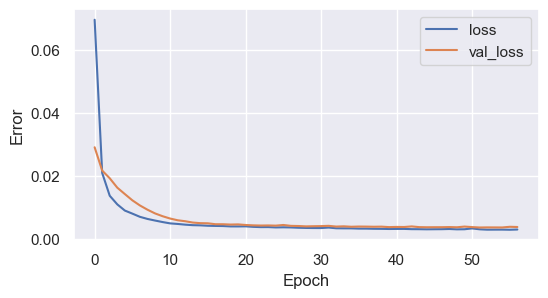

In [313]:
# make a GRU model for train1
model1 = tf.keras.Sequential([
    tf.keras.layers.GRU(32, input_shape=(12, 12)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Reshape([1, 1])
])

# fit the model
history1 = compile_and_fit(model1, train1_dataset, val1_dataset)
IPython.display.clear_output()

# performance of the model on train and validation data
model1.evaluate(train1_dataset)
model1.evaluate(val1_dataset)

# summary of the model
model1.summary()

# plot the loss and validation loss
plot_loss(history1)

5/5 [==============================] - 0s 23ms/step


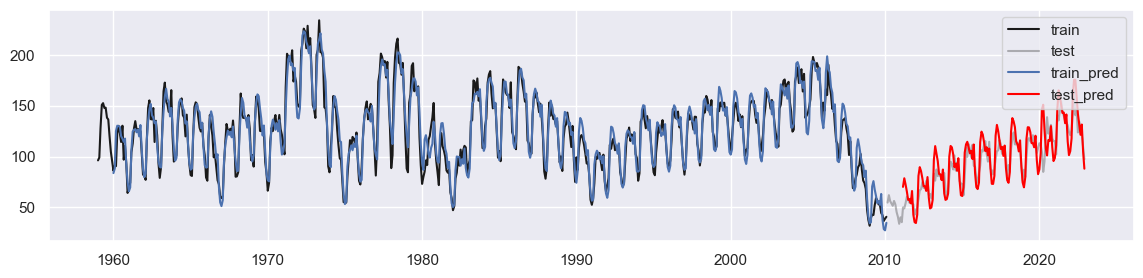

In [314]:
# make predictions on trainfull1 data and test data
train_pred1 = model1.predict(trainfull1_dataset)
test_pred1 = model1.predict(test1_dataset)

# inverse transform the predictions based on min and max of df_train
train_pred1 = scaler1.inverse_transform(train_pred1.reshape(-1, 1))
test_pred1 = scaler1.inverse_transform(test_pred1.reshape(-1, 1))

# add the predictions to the train and test data considering the window size
train1['pred_gru'] = np.nan
train1['pred_gru'].iloc[12:] = train_pred1.reshape(-1)
test1['pred_gru'] = np.nan
test1['pred_gru'].iloc[12:] = test_pred1.reshape(-1)

# plot the predictions and actual values using plot_ts function
plot_ts(train1, test1, train1['pred_gru'], test1['pred_gru'])

In [315]:
# print rmse on the train and test data
print('RMSE of GRU model on train data: {:.2f}'.format(rmse(train1[12:].ts, train1['pred_gru'][12:])))
print('RMSE of GRU model on test data: {:.2f}'.format(rmse(test1[12:].ts, test1['pred_gru'][12:])))

RMSE of GRU model on train data: 11.18
RMSE of GRU model on test data: 14.99


**For `train2`:**

 1/34 [..............................] - ETA: 0s - loss: 0.0038 - mae: 0.0503 - mse: 0.0038

9/9 [==============================] - 0s 7ms/step - loss: 0.0133 - mae: 0.0739 - mse: 0.0133
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 32)                3936      
                                                                 
 dense_20 (Dense)            (None, 1)                 33        
                                                                 
 reshape_20 (Reshape)        (None, 1, 1)              0         
                                                                 
Total params: 3,969
Trainable params: 3,969
Non-trainable params: 0
_________________________________________________________________


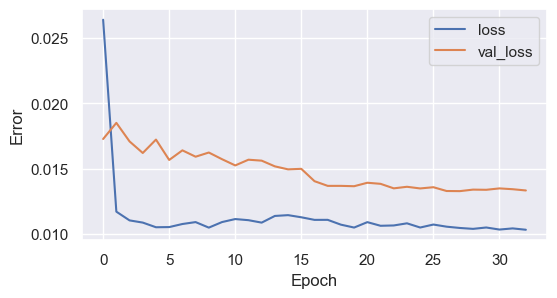

In [316]:
# make a GRU model for train2
model2 = tf.keras.Sequential([
    tf.keras.layers.GRU(32, input_shape=(7, 7)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Reshape([1, 1])
])

# fit the model
history2 = compile_and_fit(model2, train2_dataset, val2_dataset)
IPython.display.clear_output()

# performance of the model on train and validation data
model2.evaluate(train2_dataset)
model2.evaluate(val2_dataset)

# summary of the model
model2.summary()

# plot the loss and validation loss
plot_loss(history2)

11/11 [==============================] - 0s 4ms/step


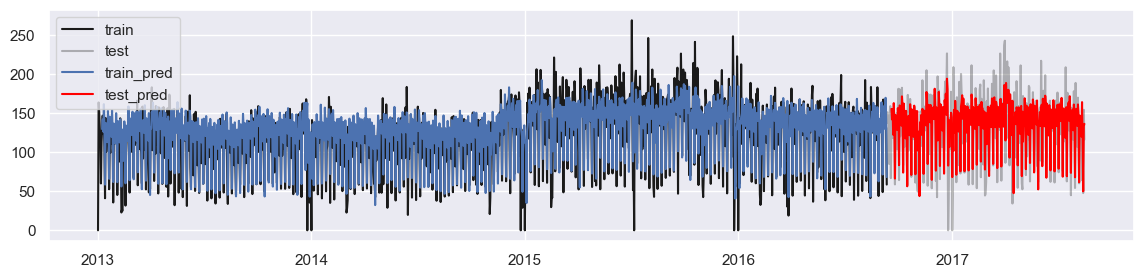

In [317]:
# make predictions on trainfull2 data and test data
train_pred2 = model2.predict(trainfull2_dataset)
test_pred2 = model2.predict(test2_dataset)

# inverse transform the predictions based on min and max of df_train
train_pred2 = scaler2.inverse_transform(train_pred2.reshape(-1, 1))
test_pred2 = scaler2.inverse_transform(test_pred2.reshape(-1, 1))

# add the predictions to the train and test data considering the window size
train2['pred_gru'] = np.nan
train2['pred_gru'].iloc[7:] = train_pred2.reshape(-1)
test2['pred_gru'] = np.nan
test2['pred_gru'].iloc[7:] = test_pred2.reshape(-1)

# plot the predictions and actual values using plot_ts function
plot_ts(train2, test2, train2['pred_gru'], test2['pred_gru'])

In [318]:
# print rmse on the train and test data
print('RMSE of GRU model on train data: {:.2f}'.format(rmse(train2[7:].ts, train2['pred_gru'][7:])))
print('RMSE of GRU model on test data: {:.2f}'.format(rmse(test2[7:].ts, test2['pred_gru'][7:])))

RMSE of GRU model on train data: 28.49
RMSE of GRU model on test data: 30.13


**For `train3`:**

 1/54 [..............................] - ETA: 1s - loss: 5.6253e-05 - mae: 0.0062 - mse: 5.6253e-05

13/13 [==============================] - 0s 12ms/step - loss: 1.0563e-04 - mae: 0.0066 - mse: 1.0563e-04
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 32)                3360      
                                                                 
 dense_21 (Dense)            (None, 1)                 33        
                                                                 
 reshape_21 (Reshape)        (None, 1, 1)              0         
                                                                 
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________


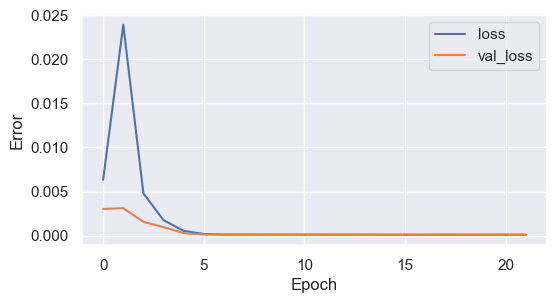

In [319]:
# make a GRU model for train3
model3 = tf.keras.Sequential([
    tf.keras.layers.GRU(32, input_shape=(50, 1)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Reshape([1, 1])
])

# fit the model
history3 = compile_and_fit(model3, train3_dataset, val3_dataset)
IPython.display.clear_output()

# performance of the model on train and validation data
model3.evaluate(train3_dataset)
model3.evaluate(val3_dataset)

# summary of the model
model3.summary()

# plot the loss and validation loss
plot_loss(history3)

16/16 [==============================] - 0s 11ms/step


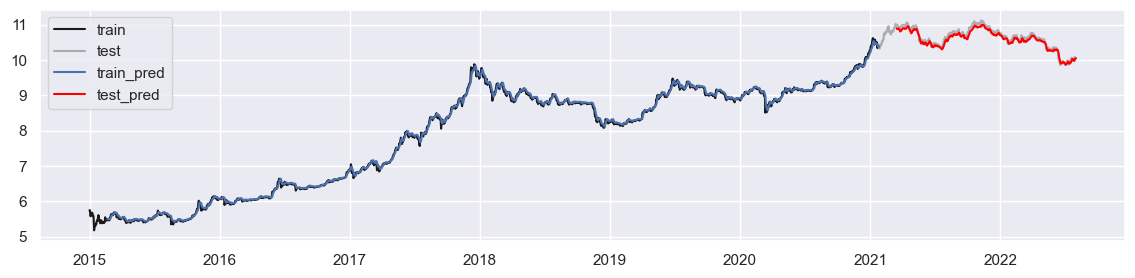

In [320]:
# make predictions on trainfull3 data and test data
train_pred3 = model3.predict(trainfull3_dataset)
test_pred3 = model3.predict(test3_dataset)

# inverse transform the predictions based on min and max of df_train
train_pred3 = scaler3.inverse_transform(train_pred3.reshape(-1, 1))
test_pred3 = scaler3.inverse_transform(test_pred3.reshape(-1, 1))

# add the predictions to the train and test data considering the window size
train3['pred_gru'] = np.nan
train3['pred_gru'].iloc[50:] = train_pred3.reshape(-1)
test3['pred_gru'] = np.nan
test3['pred_gru'].iloc[50:] = test_pred3.reshape(-1)

# plot the predictions and actual values using plot_ts function
plot_ts(train3, test3, train3['pred_gru'], test3['pred_gru'])

In [321]:
# print rmse on the train and test data
print('RMSE of GRU model on train data: {:.2f}'.format(rmse(train3[50:].ts, train3['pred_gru'][50:])))
print('RMSE of GRU model on test data: {:.2f}'.format(rmse(test3[50:].ts, test3['pred_gru'][50:])))

RMSE of GRU model on train data: 0.05
RMSE of GRU model on test data: 0.08


In [322]:
# saving train and test data
train1.to_csv('train1_pred.csv')
test1.to_csv('test1_pred.csv')
train2.to_csv('train2_pred.csv')
test2.to_csv('test2_pred.csv')
train3.to_csv('train3_pred.csv')
test3.to_csv('test3_pred.csv')